# Analysis of Genome-wide CRISPR Screen in Primary Human T Cells

Here we analyze the output of MAGeCK from the previous preprocessing Jupyter notebook following the steps below:

1. Quality control
2. Identification of positively and negatively selected genes
3. Gene set enrichment analysis

In [1]:
# load packages
library(MAGeCKFlute)
library(clusterProfiler)
library(ggplot2)
library(ggrepel)

set.seed(171336)





##############################################################################
Pathview is an open source software package distributed under GNU General
Public License version 3 (GPLv3). Details of GPLv3 is available at
http://www.gnu.org/licenses/gpl-3.0.html. Particullary, users are required to
formally cite the original Pathview paper (not just mention it) in publications
or products. For details, do citation("pathview") within R.

The pathview downloads and uses KEGG data. Non-academic uses may require a KEGG
license agreement (details at http://www.kegg.jp/kegg/legal.html).
##############################################################################

clusterProfiler v4.10.0  For help: https://yulab-smu.top/biomedical-knowledge-mining-book/

If you use clusterProfiler in published research, please cite:
T Wu, E Hu, S Xu, M Chen, P Guo, Z Dai, T Feng, L Zhou, W Tang, L Zhan, X Fu, S Liu, X Bo, and G Yu. clusterProfiler 4.0: A universal enrichment tool for interpreting omics da

In [2]:
# increase size of plots from default
options(repr.plot.width = 14, 
        repr.plot.height = 14) # from 7, 7

## 1. Quality Control

This step uses the count summary output after mapping the raw FASTQ reads to the sgRNA library using `mageck count`. 

We look at three things:
- how evenly are the counts distributed among the sgRNAs?
- how many sgRNAs were missed (i.e. have zero counts)?
- what fraction of the reads did not map to the sgRNA library?

In [3]:
## QC
# count summary from mageck count
file1 <- "gw01.countsummary.txt"
countsummary <- read.delim(file1, check.names = FALSE)
countsummary

File                   Label     Reads    Mapped   Percentage TotalsgRNAs
1 fastq/SRR7741075.fastq D3_Div    43100130 37831149 0.8778     77441      
2 fastq/SRR7741076.fastq D3_NonDiv 60320529 53469548 0.8864     77441      
3 fastq/SRR7741083.fastq D4_Div    53785275 47475663 0.8827     77441      
4 fastq/SRR7741084.fastq D4_NonDiv 49559785 43715730 0.8821     77441      
5 fastq/SRR7741089.fastq D5_NonDiv 40626205 36071337 0.8879     77441      
6 fastq/SRR7741090.fastq D5_Div    41609090 36606786 0.8798     77441      
7 fastq/SRR7741091.fastq D6_NonDiv 37522017 32880702 0.8763     77441      
8 fastq/SRR7741092.fastq D6_Div    38830899 34336570 0.8843     77441      
  Zerocounts GiniIndex NegSelQC NegSelQCPval NegSelQCPvalPermutation
1 274        0.06573   0        1            1                      
2 222        0.05852   0        1            1                      
3 198        0.05901   0        1            1                      
4 173        0.05830   0        1            1                      
5 237        0.06038   0        1            1                      
6 271        0.06325   0        1            1                      
7 283        0.06399   0        1            1                      
8 315        0.06957   0        1            1                      
  NegSelQCPvalPermutationFDR NegSelQCGene
1 1                          0           
2 1                          0           
3 1                          0           
4 1                          0           
5 1                          0           
6 1                          0           
7 1                          0           
8 1                          0

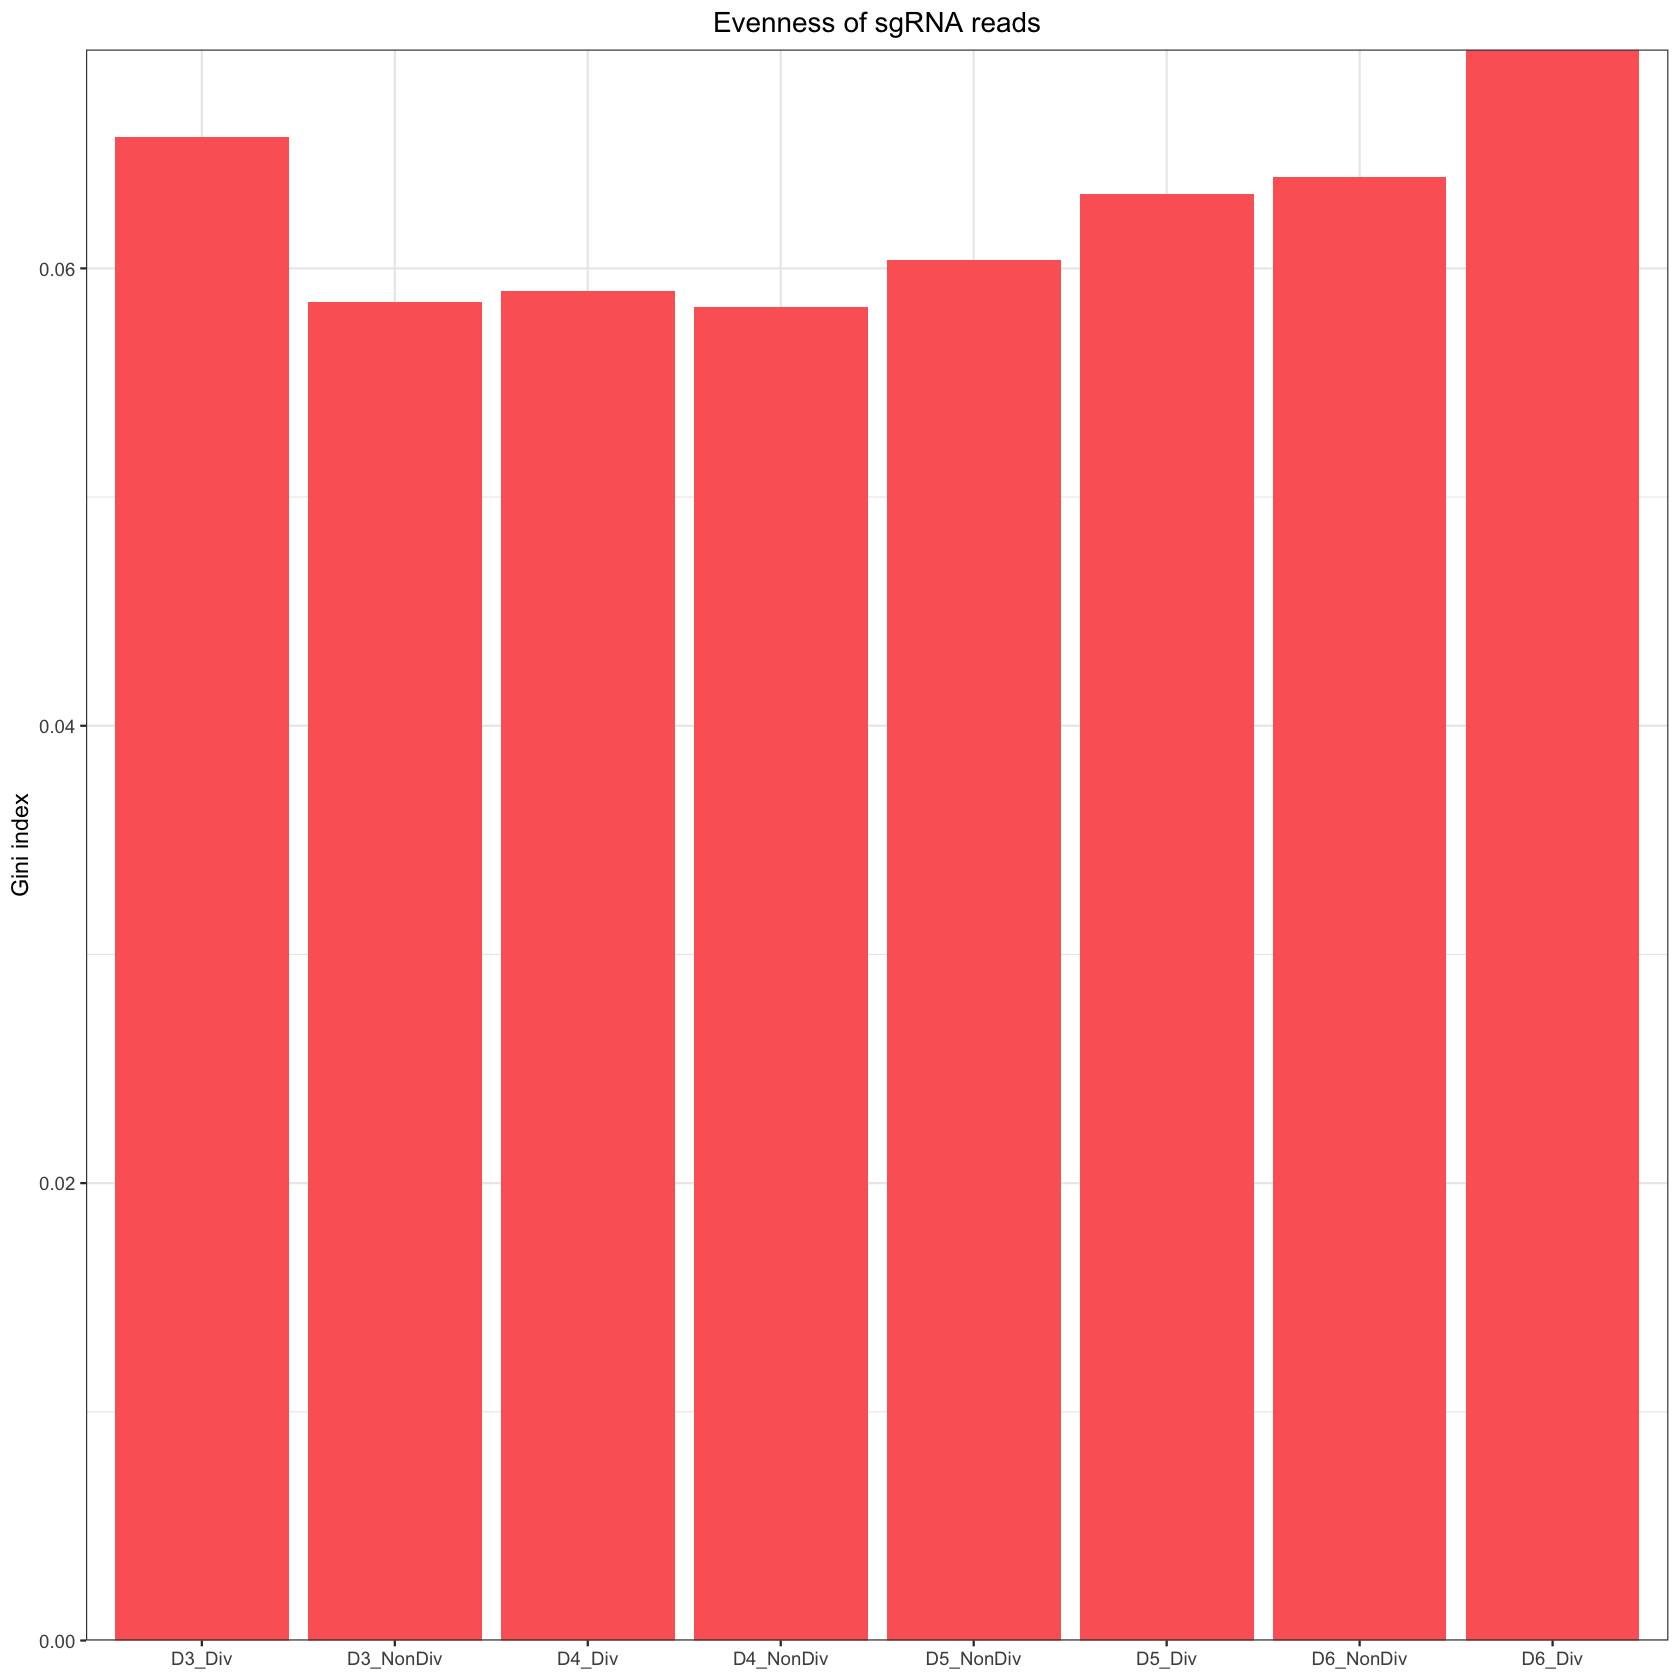

In [4]:
# Gini index - smaller value indicates more eveness of the count distribution. 
# (Recommended: around 0.1 for plasmid or initial state samples, and around 0.2-0.3 for negative selection samples)
BarView(countsummary, x = "Label", y = "GiniIndex",
        ylab = "Gini index", main = "Evenness of sgRNA reads")

- Gini Index is below 0.1 for all 8 samples indicating uniform representation of sgRNAs within a sample. This implies minimal bias/over-amplification of specific sgRNAs during library preparation or sequencing. 

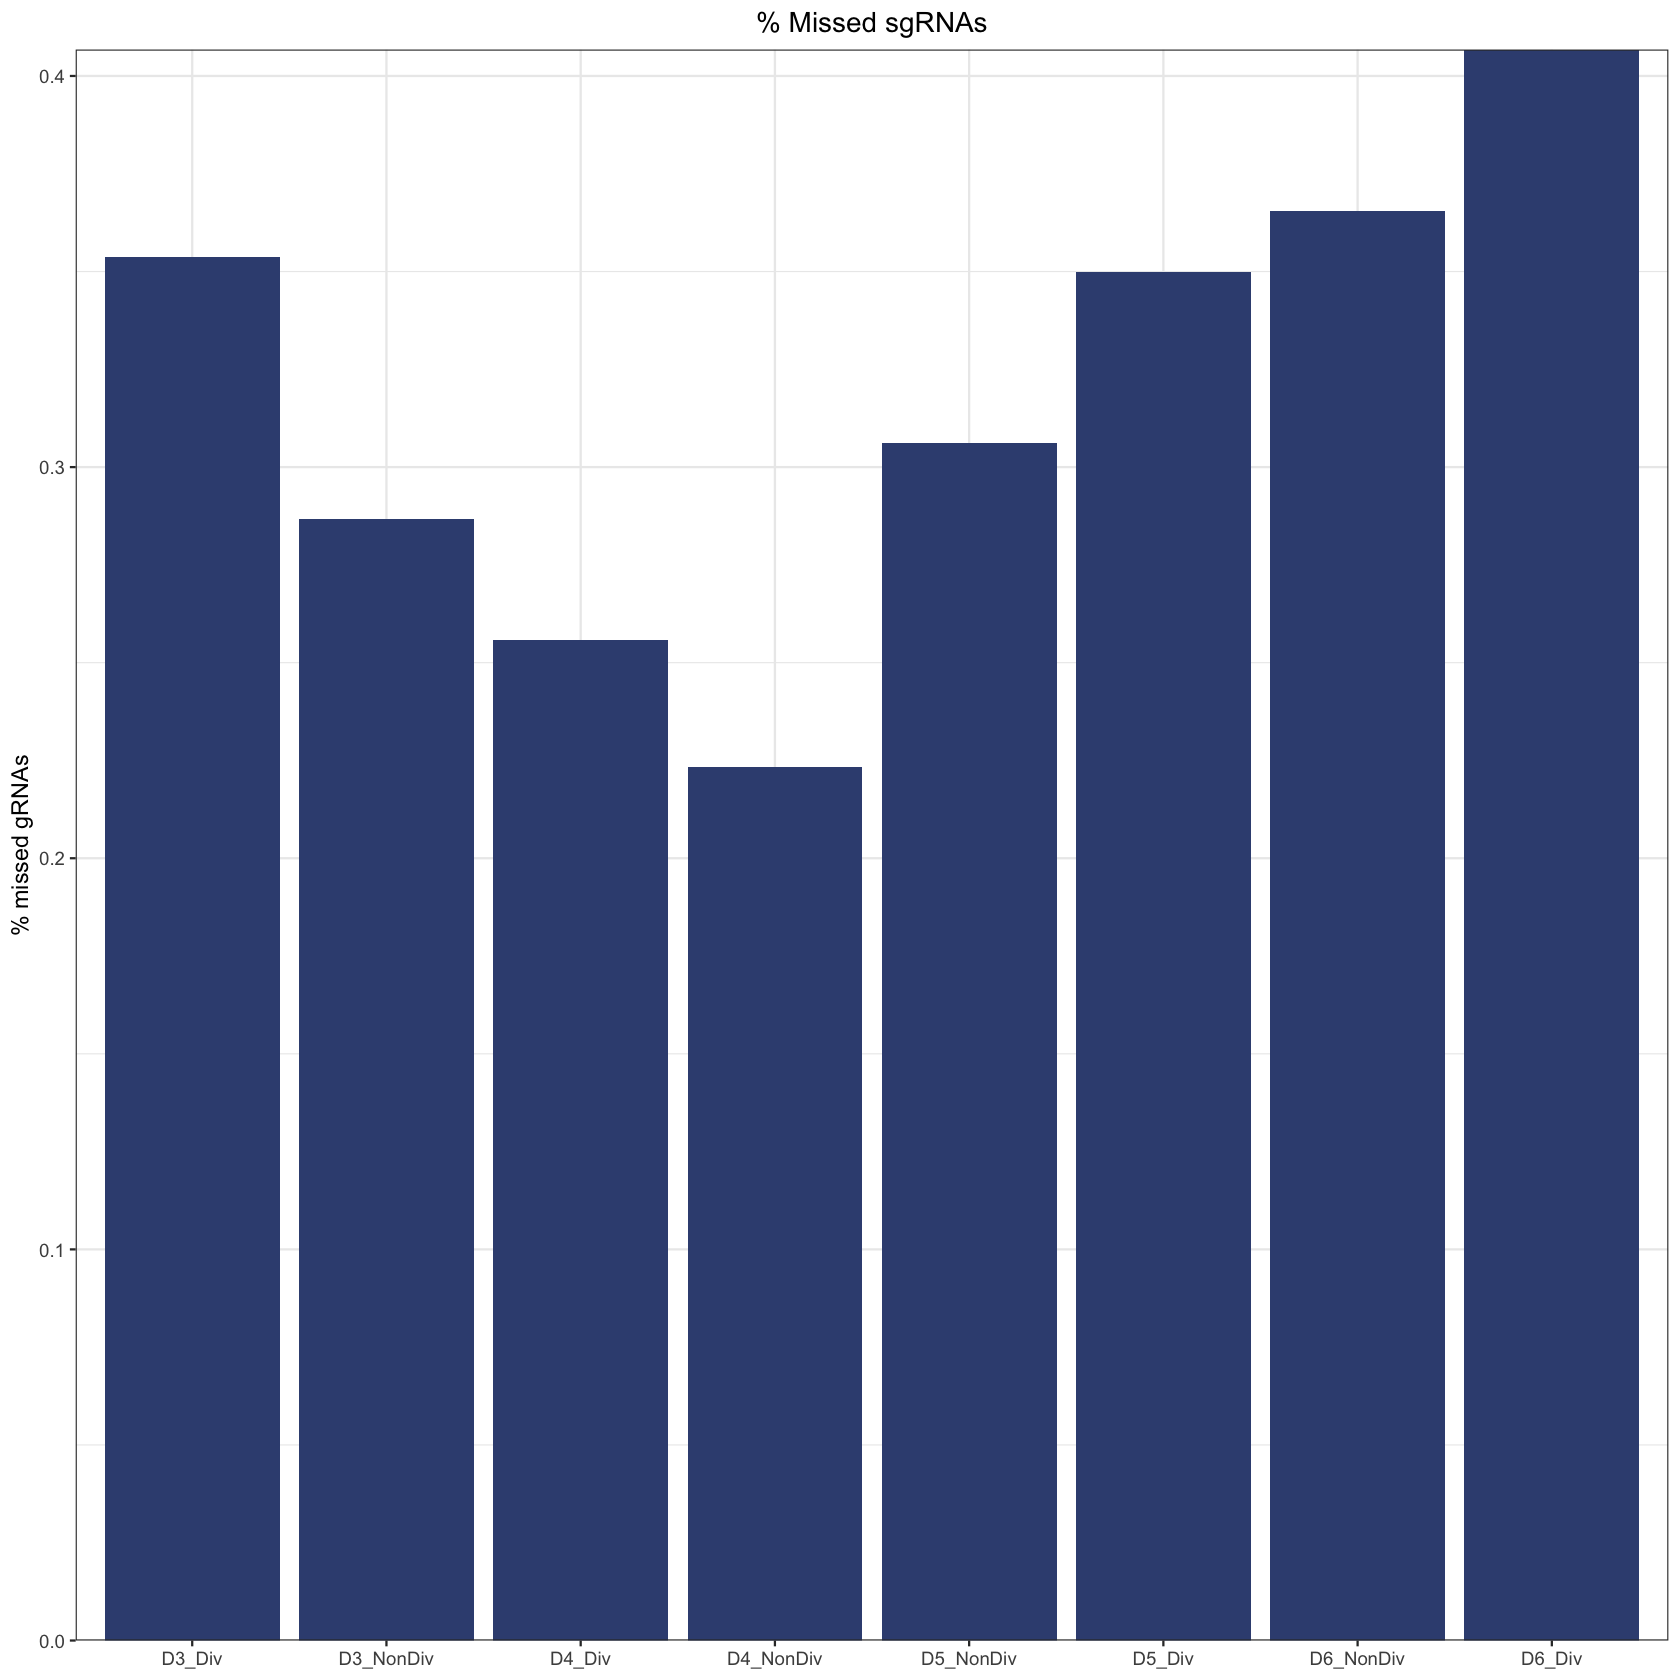

In [5]:
# Missed sgRNAs: sgRNAs that have 0 counts (Recommended: no more than 1%)
countsummary$Missed = 100*(countsummary$Zerocounts/countsummary$TotalsgRNAs)
BarView(countsummary, x = "Label", y = "Missed", fill = "#394E80",
        ylab = "% missed gRNAs", main = "% Missed sgRNAs")

- more than 99.5% of sgRNAs were detected in all the samples.

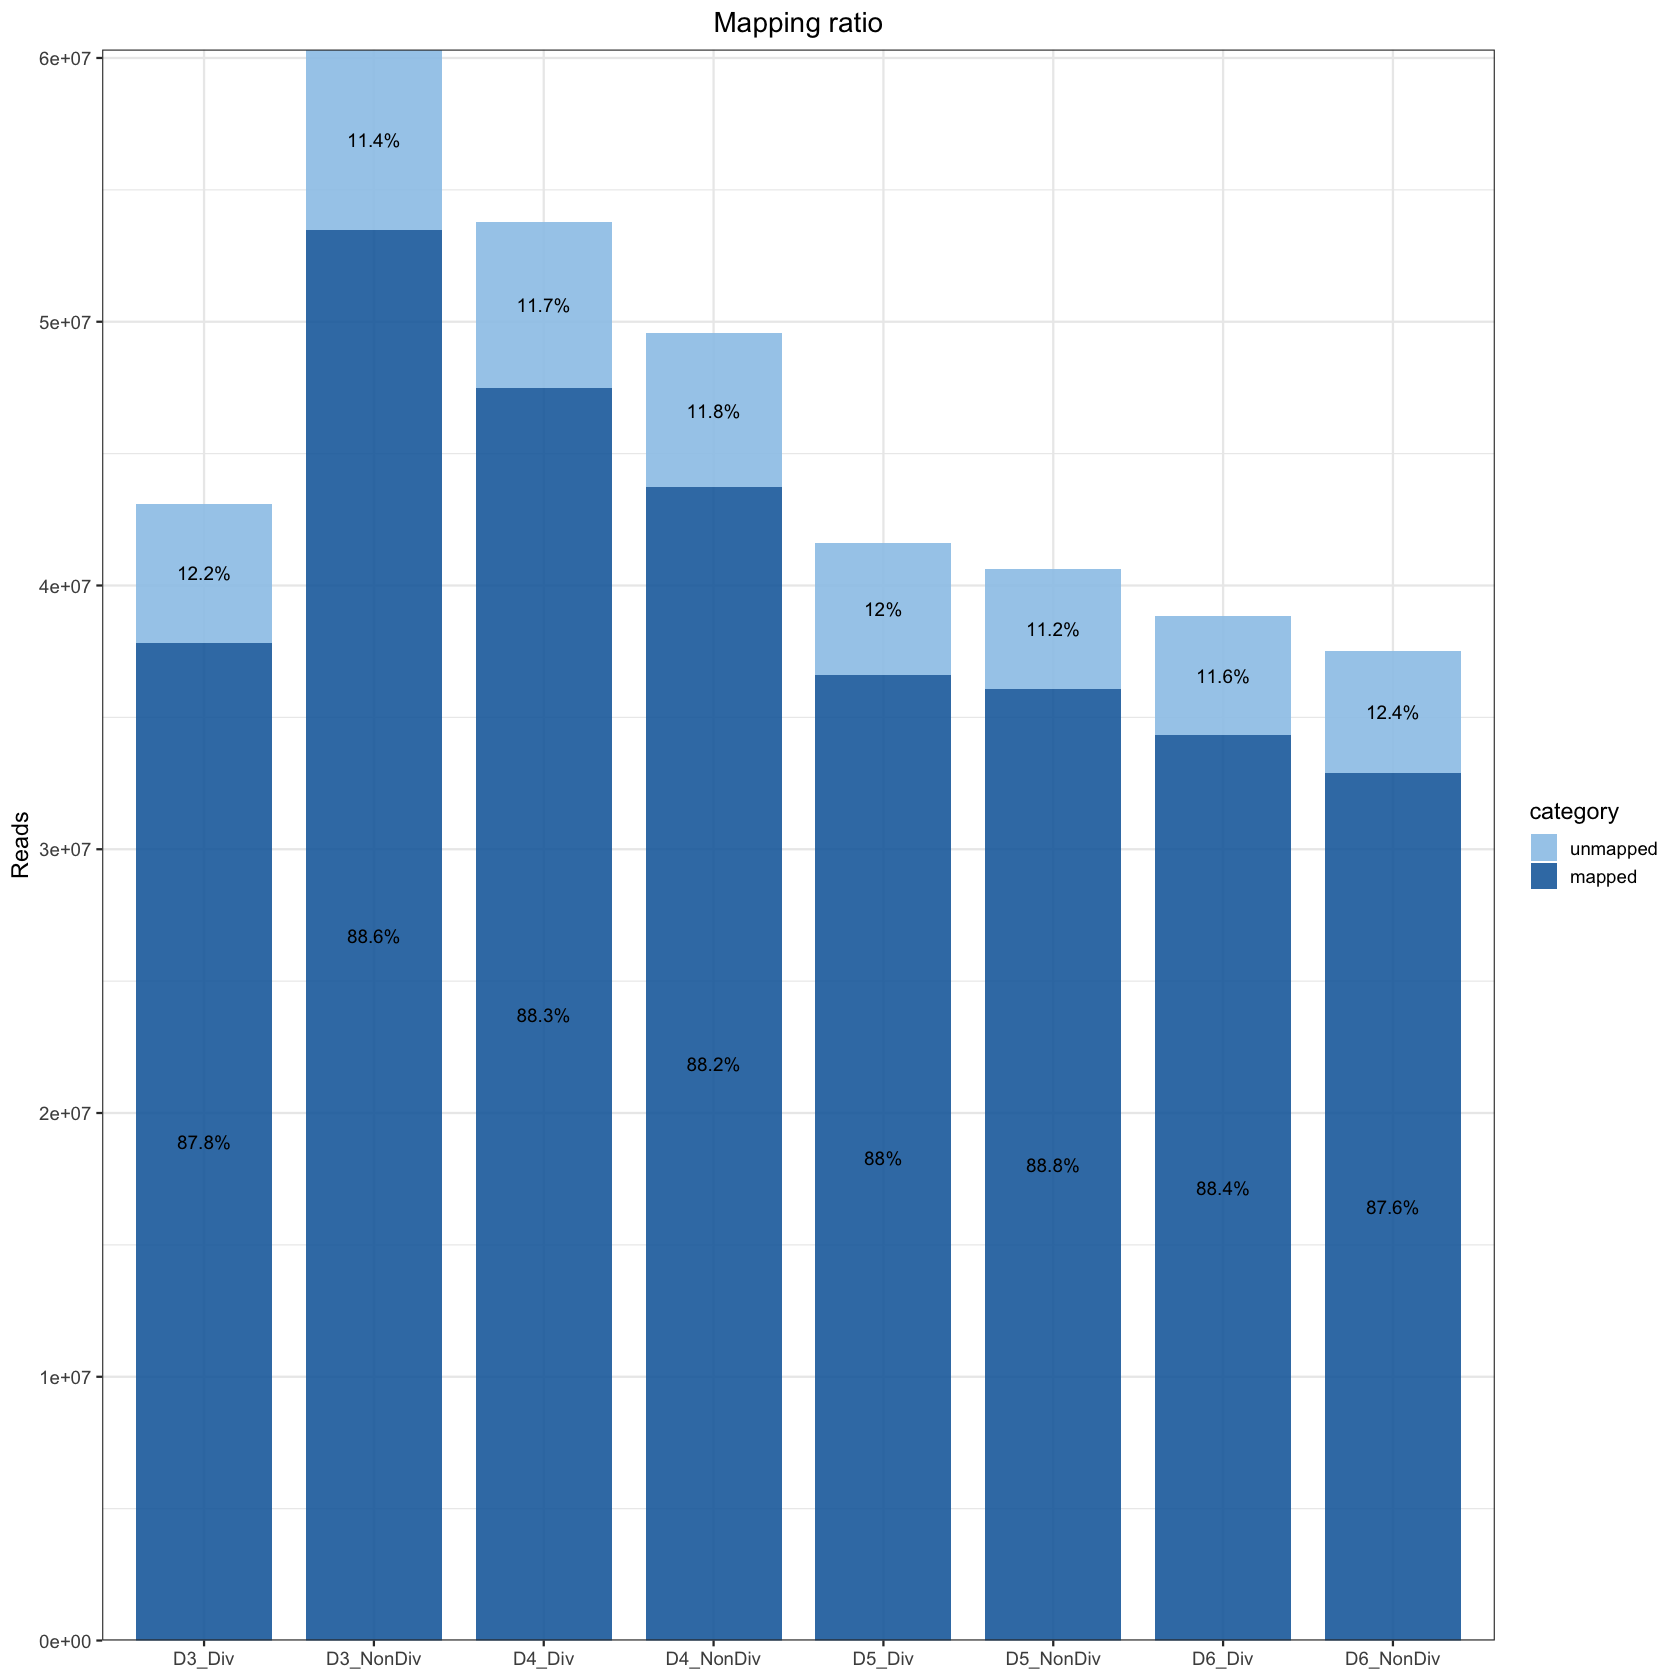

In [6]:
# Read mapping
# Reads: (Recommended: 100~300 times the number of sgRNAs)
# mapping percentage: calculated as Mapped/Reads (Recommended: at least 60%)
MapRatesView(countsummary)

- have > 2,000,000 reads in each sample (~20,000 sgRNAs * at least 100 reads recommended per sgRNA)
- have > 85% reads mapped (recommended > 60%)

## 2. Identification of positive and negative selections

Next, the gene summary file output by `mageck count` can be used to identify what genes were positively selected or negatively selected.

In [23]:
# read output from mageck test
## path to the gene summary file
file1 <- "gw01_test.gene_summary.txt"
## path to the sgRNA summary file 
file2 <- "gw01_test.sgrna_summary.txt"
gene_data <- ReadRRA(file1)
gene_data
sgrna_data <- ReadsgRRA(file2)
head(sgrna_data)

id       Score    FDR     
1     HSPA8    -0.98591 6.6e-05 
2     LCP2     -1.72740 6.6e-05 
3     EXOSC6   -1.06430 6.6e-05 
4     LCK      -0.66246 6.6e-05 
5     TAF1C    -0.54272 6.6e-05 
6     MYC      -0.91750 6.6e-05 
7     CD3D     -1.65240 6.6e-05 
8     CD247    -1.15160 6.6e-05 
9     SH2D1A   -0.59655 6.6e-05 
10    DPH3     -0.49127 6.6e-05 
11    VAV1     -1.67470 6.6e-05 
12    NOP14    -0.82098 6.6e-05 
13    CCND2    -0.45585 6.6e-05 
14    DAD1     -1.18270 6.6e-05 
15    RPP21    -0.90581 6.6e-05 
16    EXOSC8   -0.45572 6.6e-05 
17    TRMT112  -1.08290 6.6e-05 
18    NAA10    -0.80455 6.6e-05 
19    RHOH     -0.90544 6.6e-05 
20    LAT      -1.21750 6.6e-05 
21    NELFCD   -0.52711 6.6e-05 
22    GRPEL1   -0.81949 6.6e-05 
23    EIF2B4   -0.63326 6.6e-05 
24    SUPT4H1  -1.39380 6.6e-05 
25    TAF6     -1.22730 6.6e-05 
26    RELA     -0.74673 6.6e-05 
27    NOL10    -0.55854 6.6e-05 
28    SLC7A6OS -0.55532 6.6e-05 
29    NOP2     -0.79040 6.6e-05 
30    EIF2B3   -0.72702 6.6e-05 
⋮     ⋮        ⋮        ⋮       
19083 TIFA     0.16098  1.000000
19084 ABLIM2   0.24427  1.000000
19085 MYLK     0.22558  1.000000
19086 HSPA1A   0.42857  0.751303
19087 KIAA1958 0.22939  1.000000
19088 GOLPH3   0.27279  1.000000
19089 H1FOO    0.14642  1.000000
19090 NMT1     0.41640  1.000000
19091 FAM102A  0.22730  1.000000
19092 CPXM2    0.19416  1.000000
19093 IKBKE    0.28408  1.000000
19094 ARIH2    0.27439  0.561642
19095 DGKA     0.51962  0.378812
19096 ACSL4    0.20246  0.937331
19097 SOCS1    0.70862  0.000619
19098 DEFB1    0.24148  0.935997
19099 DUSP4    0.43388  0.075422
19100 RNF186   0.27540  0.672866
19101 CDK12    0.29044  0.590711
19102 GNA13    0.26887  0.561642
19103 UBASH3A  0.56516  0.000619
19104 ARID1A   0.42438  0.075422
19105 ATP8B4   0.65520  0.360767
19106 RASA2    0.52889  0.000619
19107 CBLB     1.12550  0.000619
19108 RPRD1B   0.50122  0.059736
19109 CD8A     0.64707  0.059736
19110 MEF2D    0.34340  0.002750
19111 TMEM222  0.89430  0.000619
19112 DGKZ     0.53615  0.000619

sgrna                             Gene   LFC     FDR        
1 CBLB_2430_TGCACAGAACTATCGTACCA    CBLB    1.9261 4.9297e-117
2 CBLB_2432_TTCCGCAAAATAGAGCCCCA    CBLB    1.5457  9.1095e-40
3 TCEB2_18807_GAGCAGCGGCTGTACAAGGT  TCEB2   1.3676  7.4734e-33
4 CD5_2575_CGGCTCAGCTGGTATGACCC     CD5     1.3690  6.0171e-28
5 LCP2_10545_AGCCACGAAGAGGACAATGG   LCP2   -2.7655  4.8860e-15
6 CHMP2A_35858_TCTCTAGTTTCTGTCGCTCG CHMP2A  3.3514  8.5888e-13

We can now visualize the positively and negatively selected genes in various ways.

Warning message:
“ggrepel: 6 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


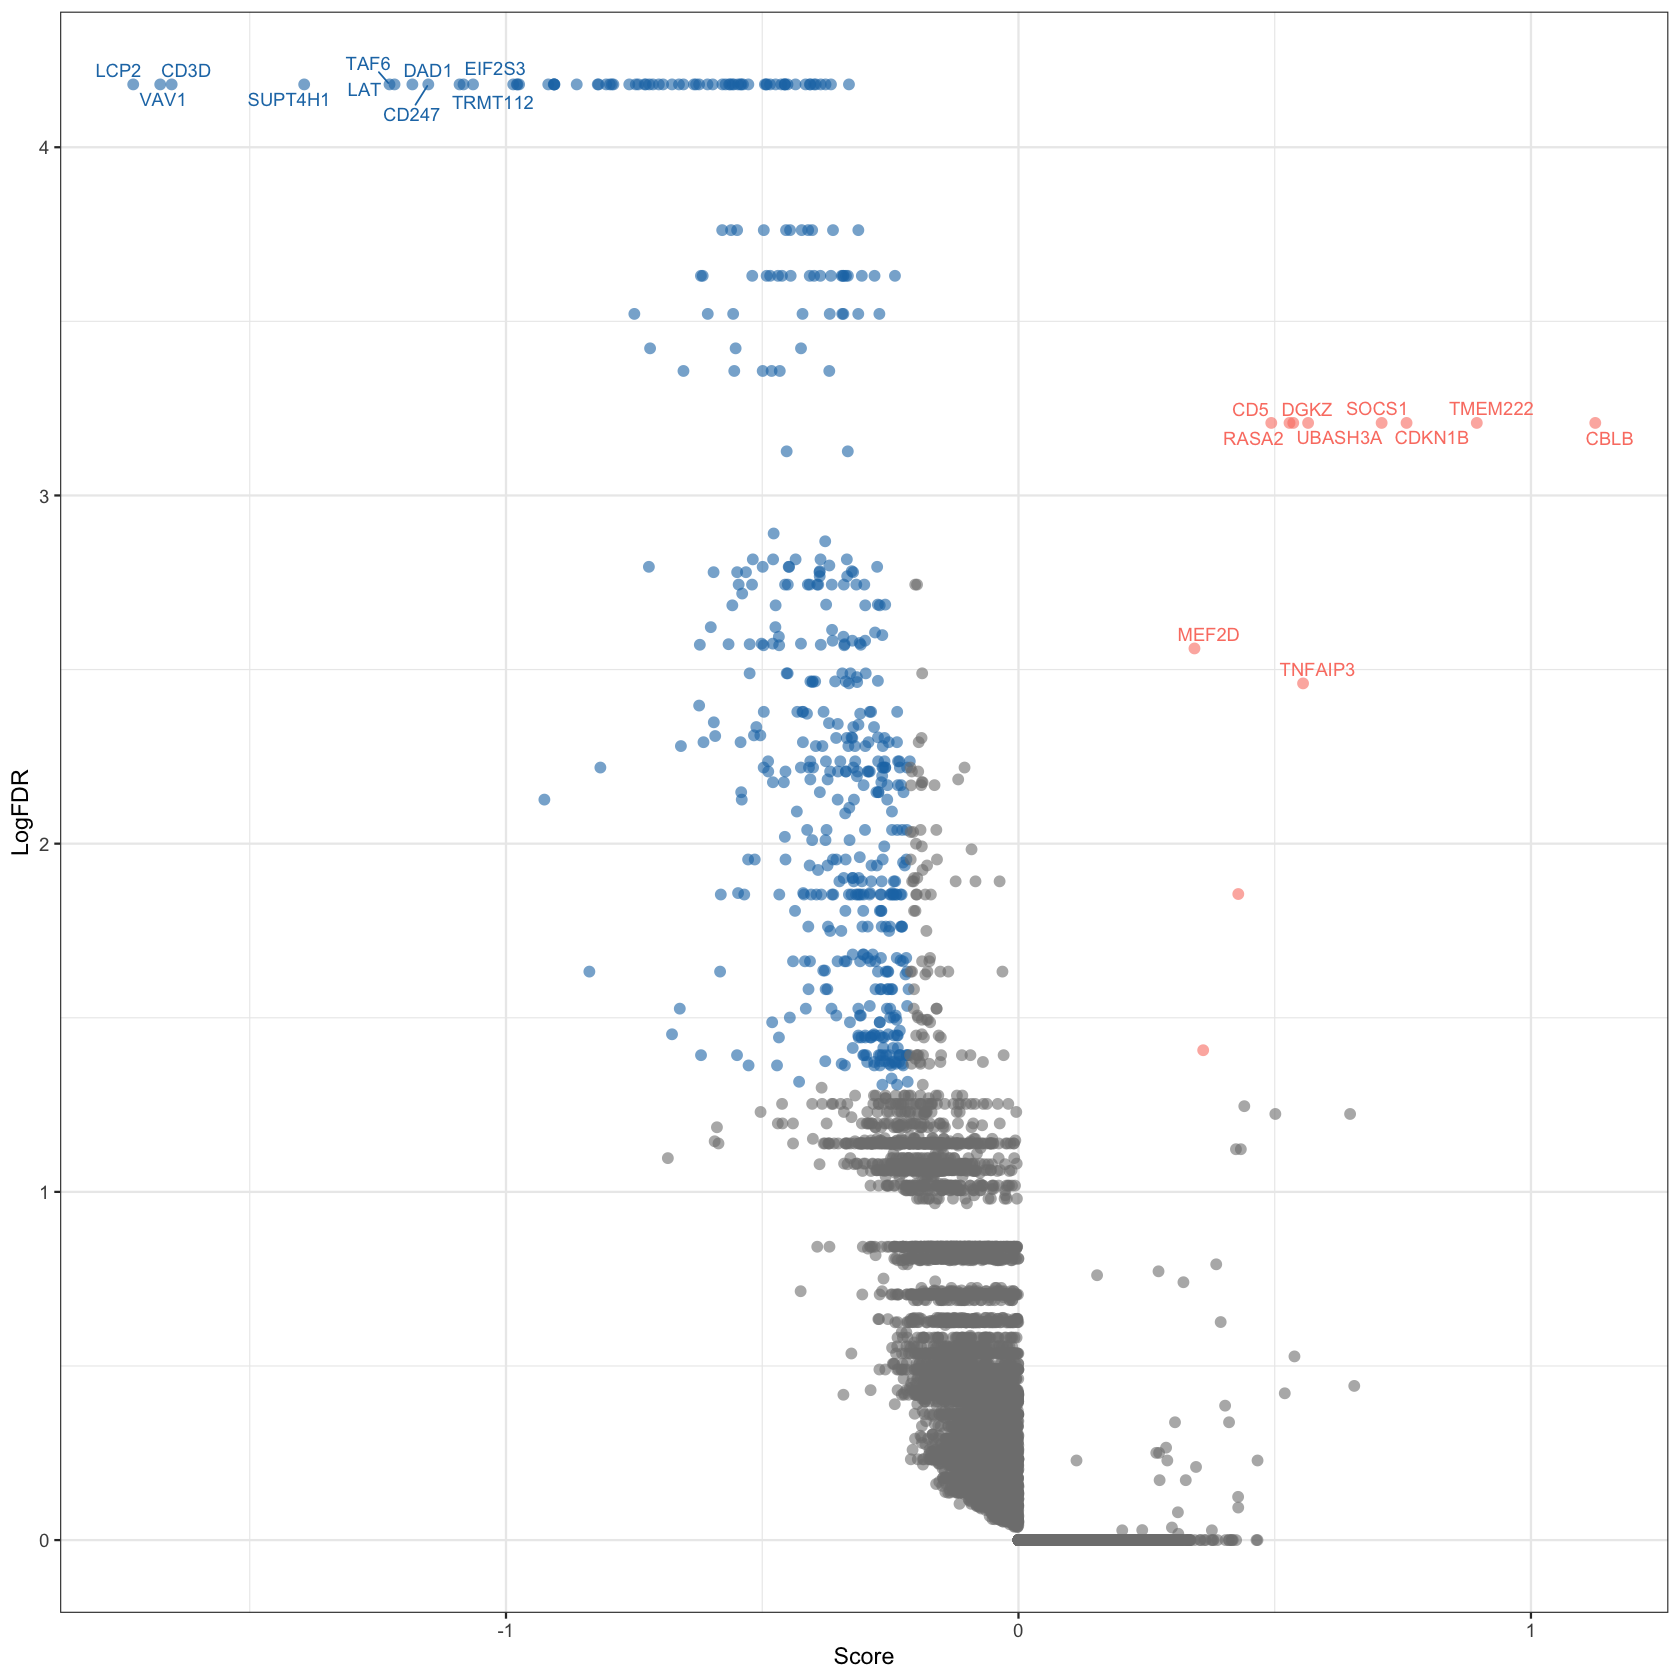

In [8]:
# volcano plot
gene_data$LogFDR <- -log10(gene_data$FDR)
p1 <- ScatterView(gene_data, x = "Score", y = "LogFDR", label = "id", 
                 model = "volcano", top = 10, 
                size = 3)
print(p1)

Warning message:
“ggrepel: 4 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


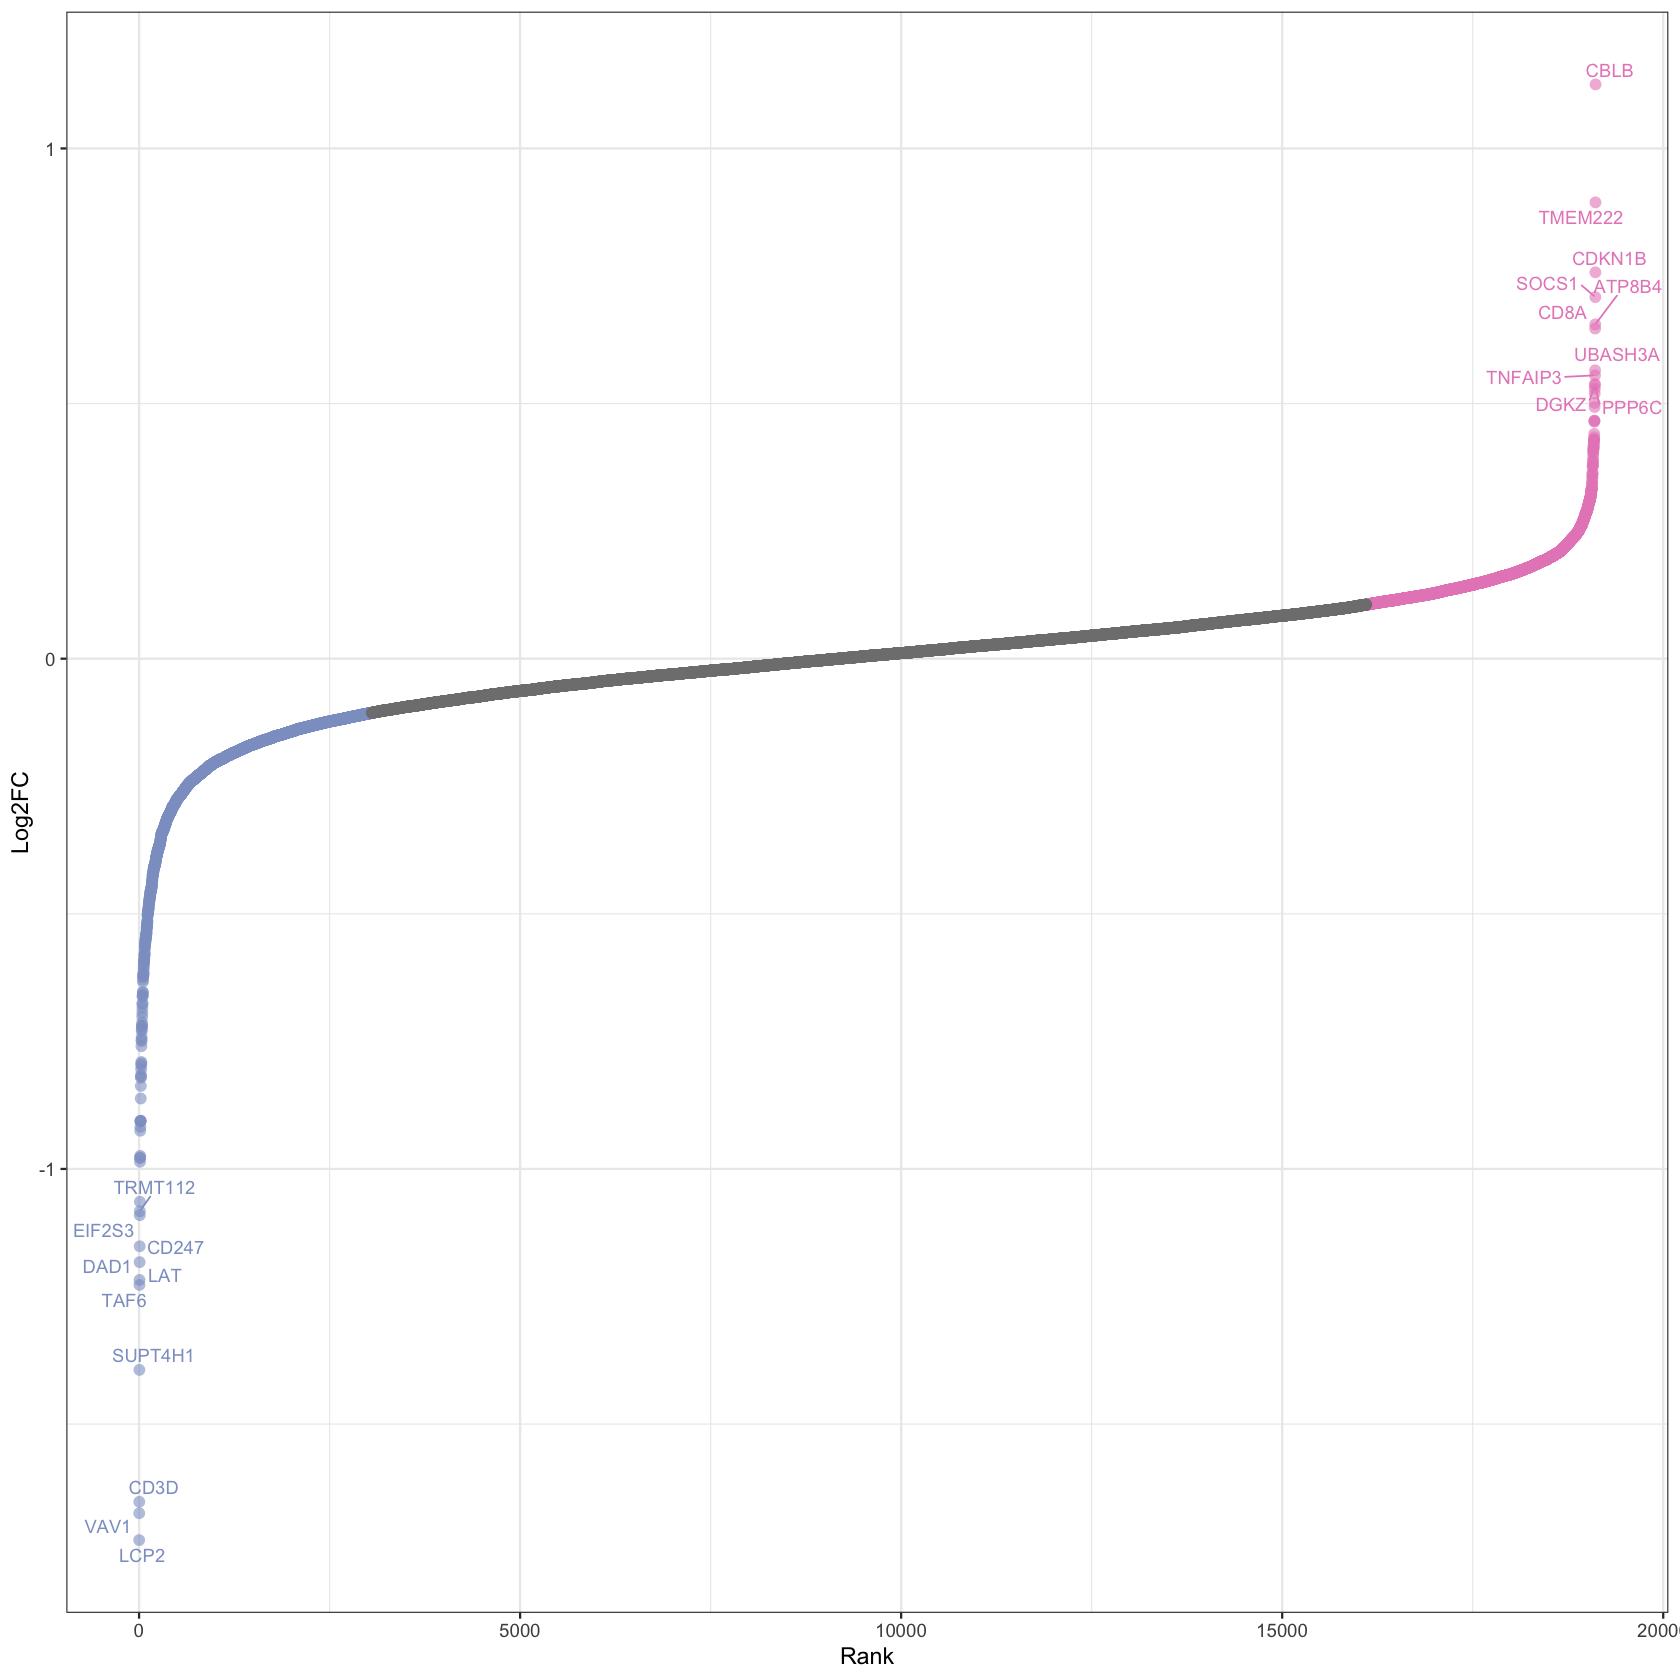

In [9]:
# Rank all the genes based on their scores and label genes in the rank plot
gene_data$Rank <- rank(gene_data$Score)
p1 <- ScatterView(gene_data, x = "Rank", y = "Score", label = "id", 
                 top = 10, auto_cut_y = TRUE, ylab = "Log2FC", 
                 groups = c("top", "bottom"), size = 3)
print(p1)

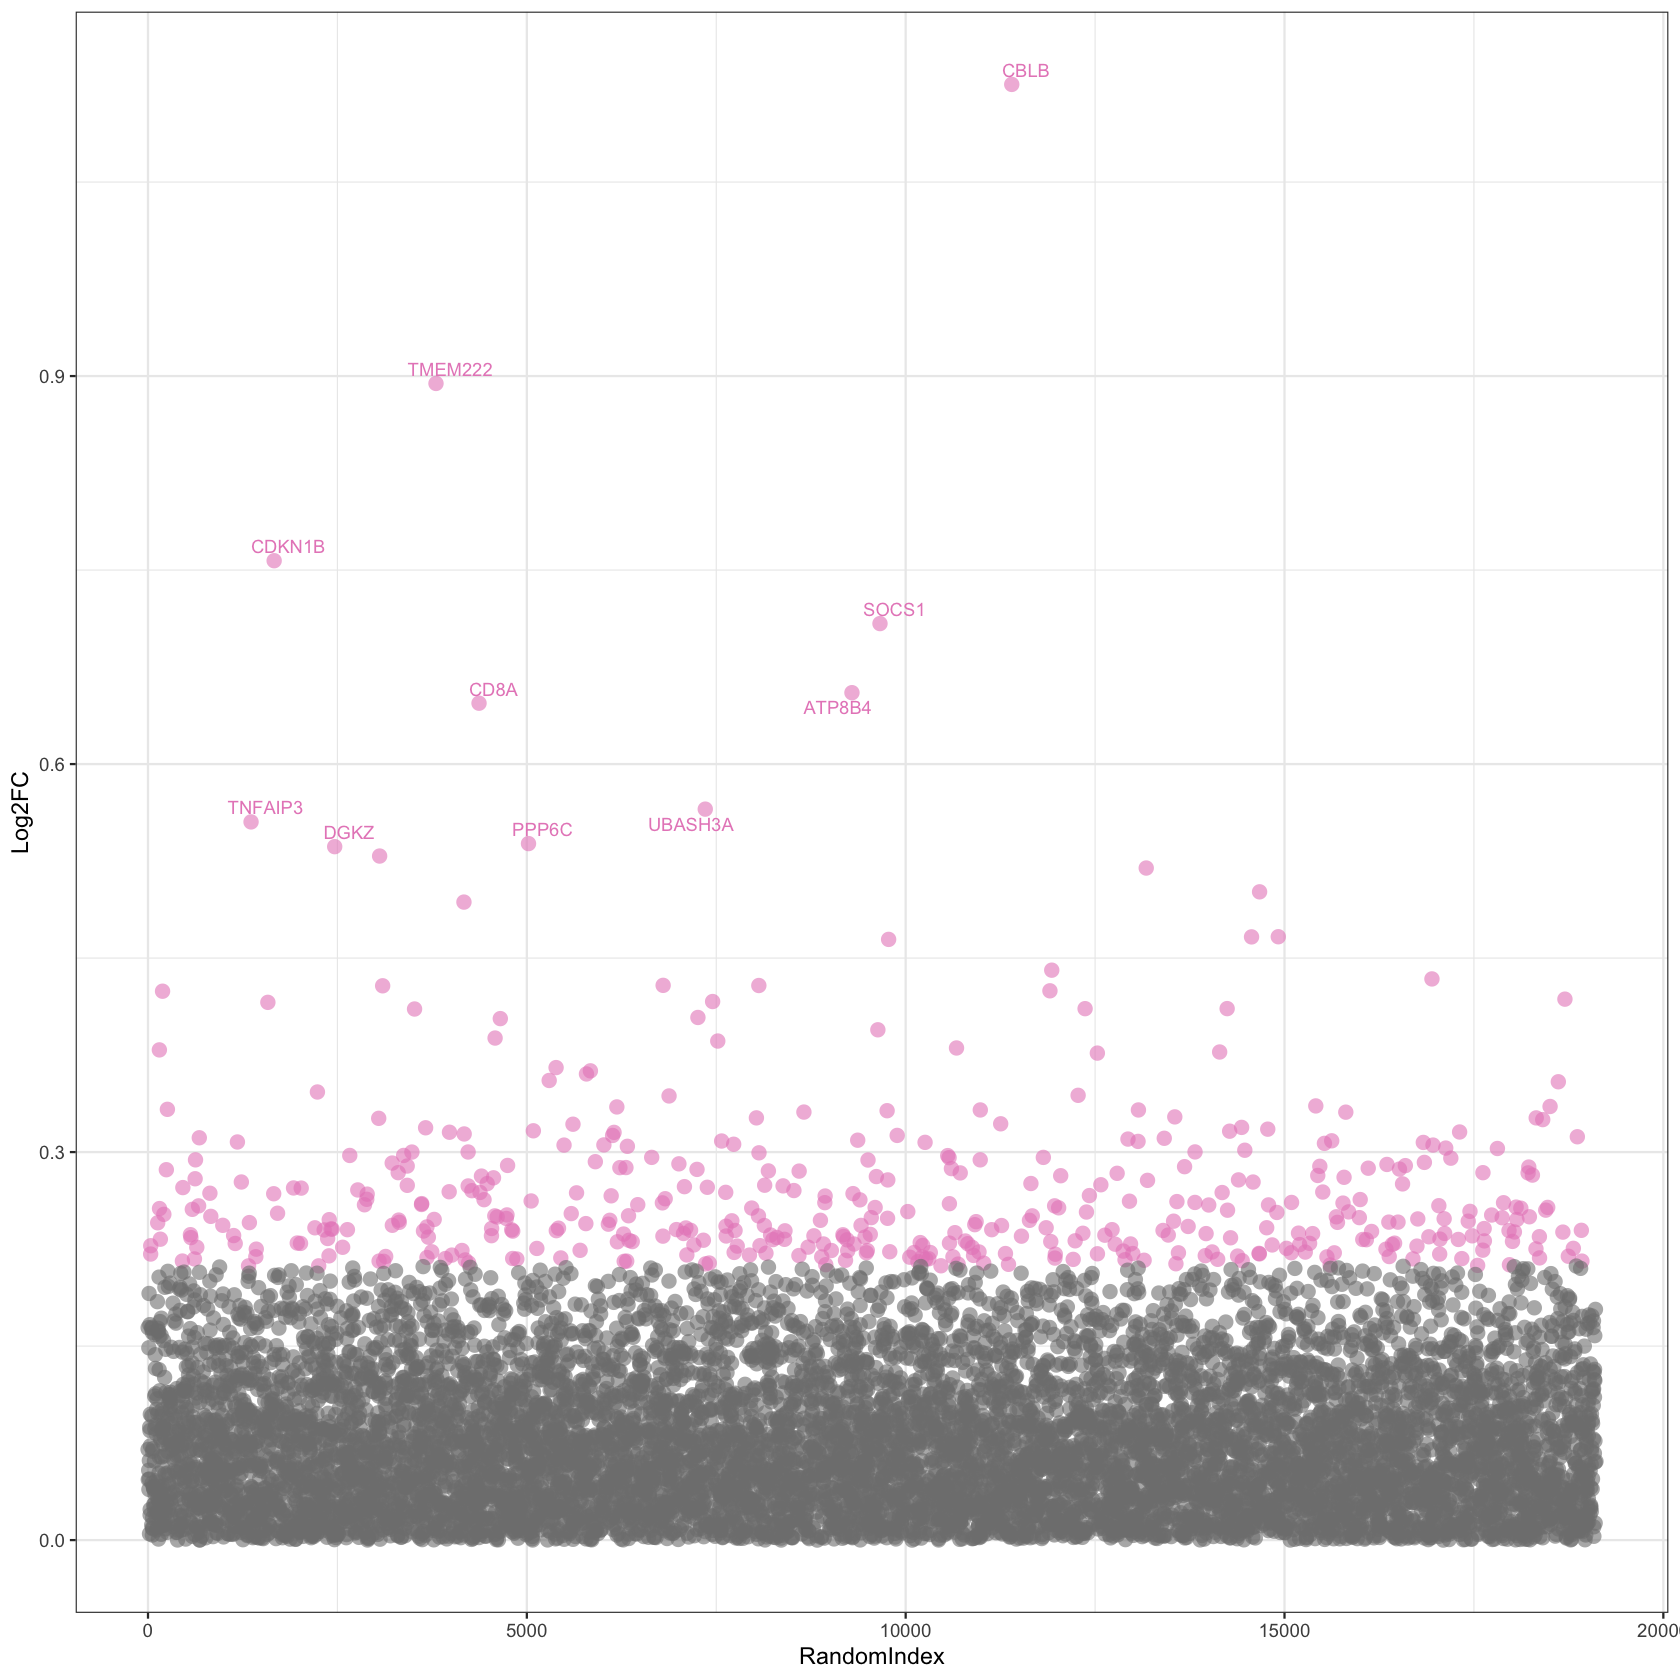

In [10]:
# positively selected genes
gene_data$RandomIndex <- sample(1:nrow(gene_data), nrow(gene_data))
gene_data <- gene_data[order(-gene_data$Score), ]
gg <- gene_data[gene_data$Score > 0, ]
p1 <- ScatterView(gg, x = "RandomIndex", y = "Score", label = "id",
                 y_cut = CutoffCalling(gene_data$Score,2), 
                 groups = "top", top = 10, ylab = "Log2FC", size = 4)
p1

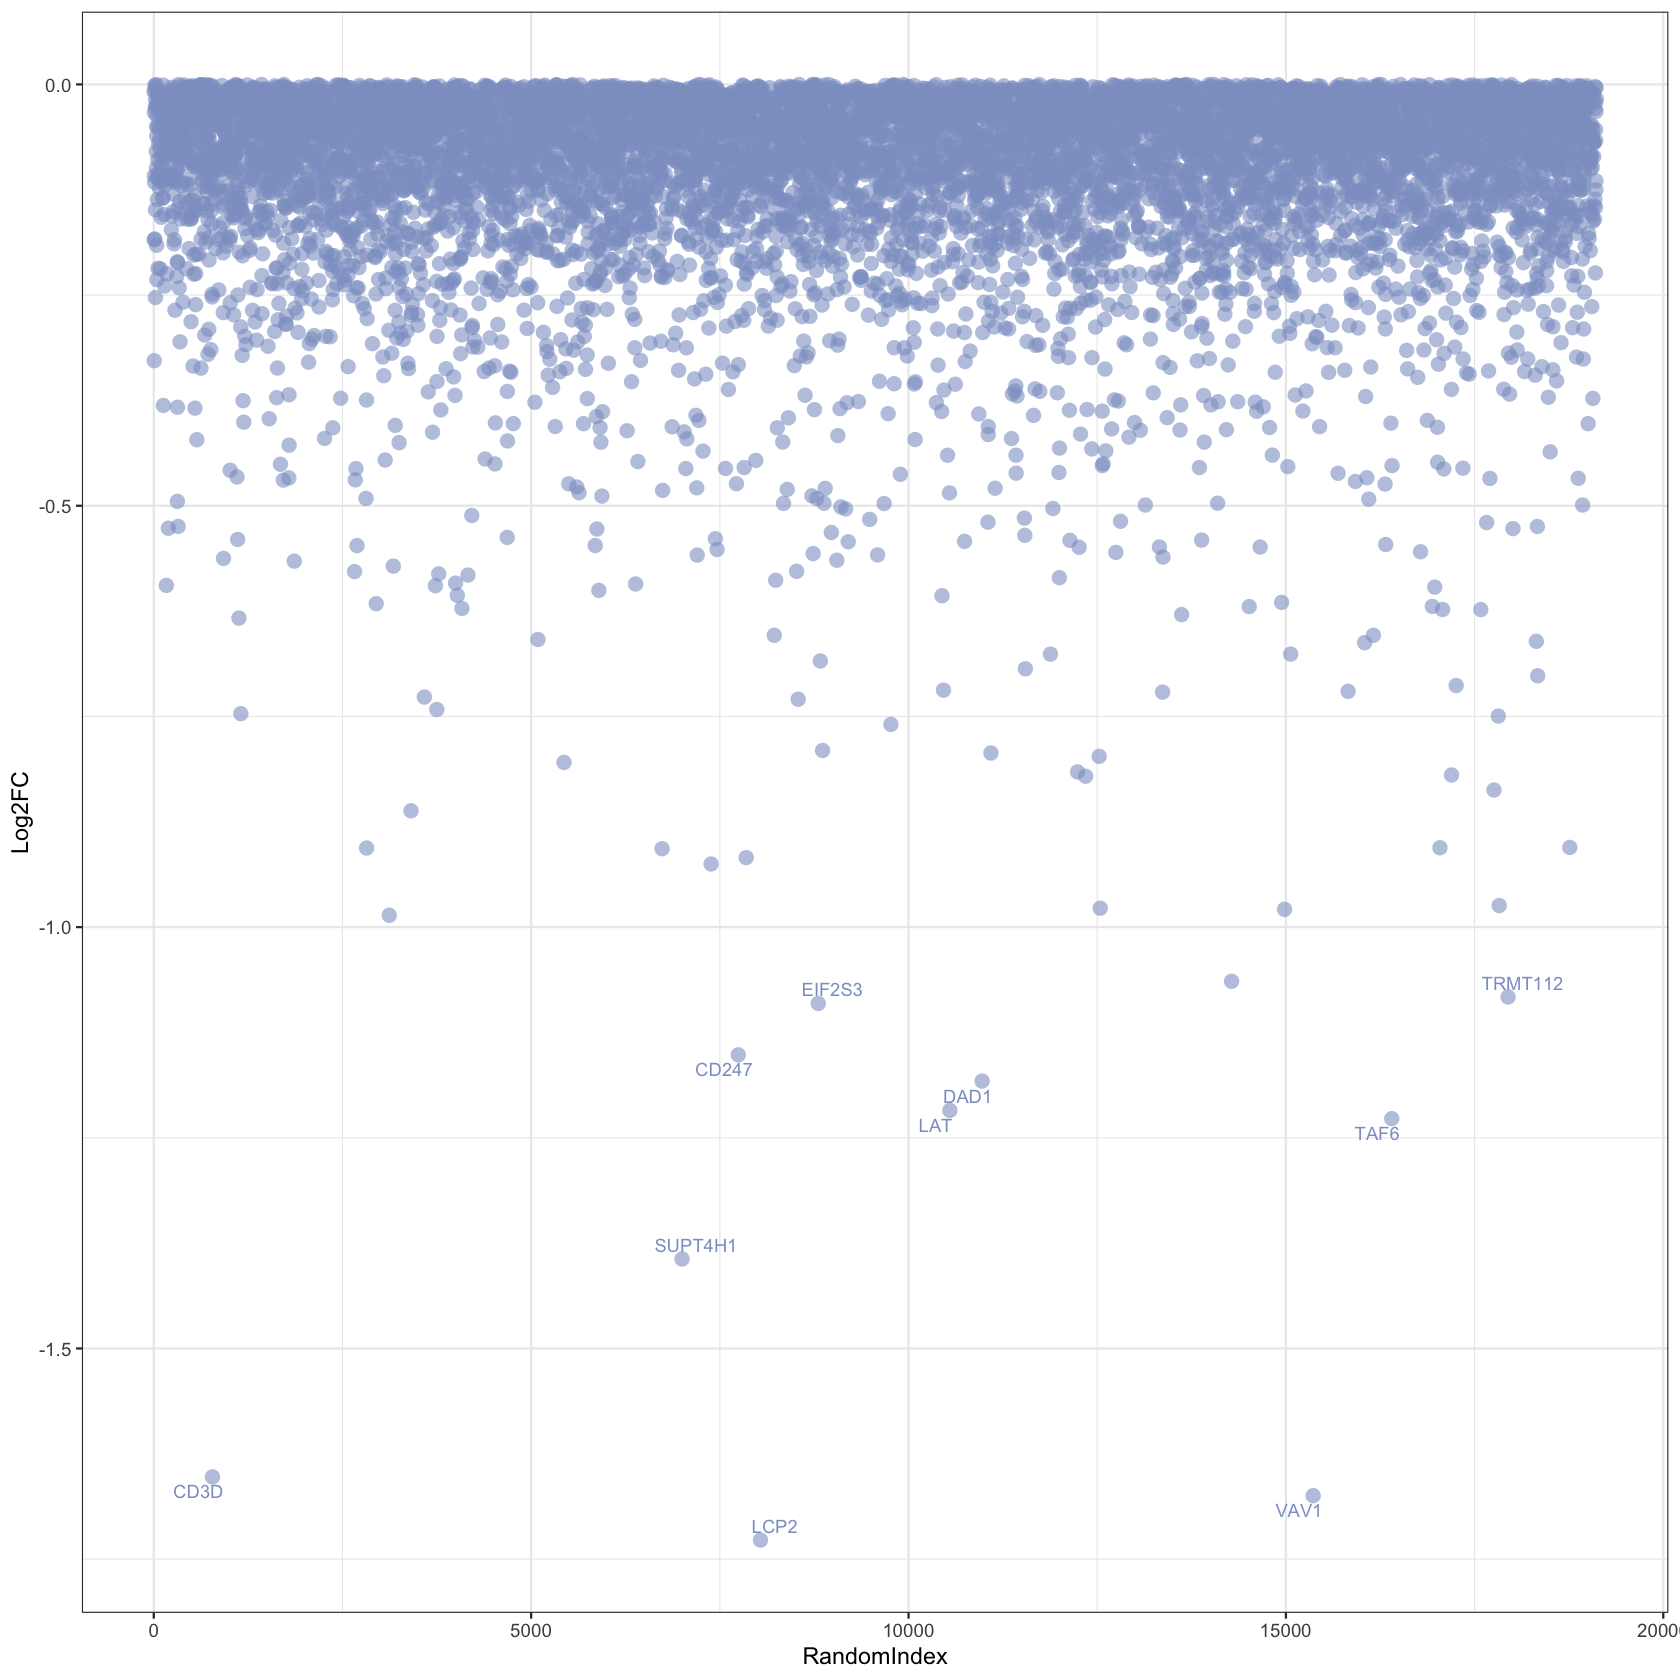

In [11]:
# negatively selected genes
gg <- gene_data[gene_data$Score < 0, ]
p2 <- ScatterView(gg, x = "RandomIndex", y = "Score", label = "id",
                 y_cut = CutoffCalling(gene_data$Score, 2), 
                 groups = "bottom", top = 10, ylab = "Log2FC", size = 4)
p2

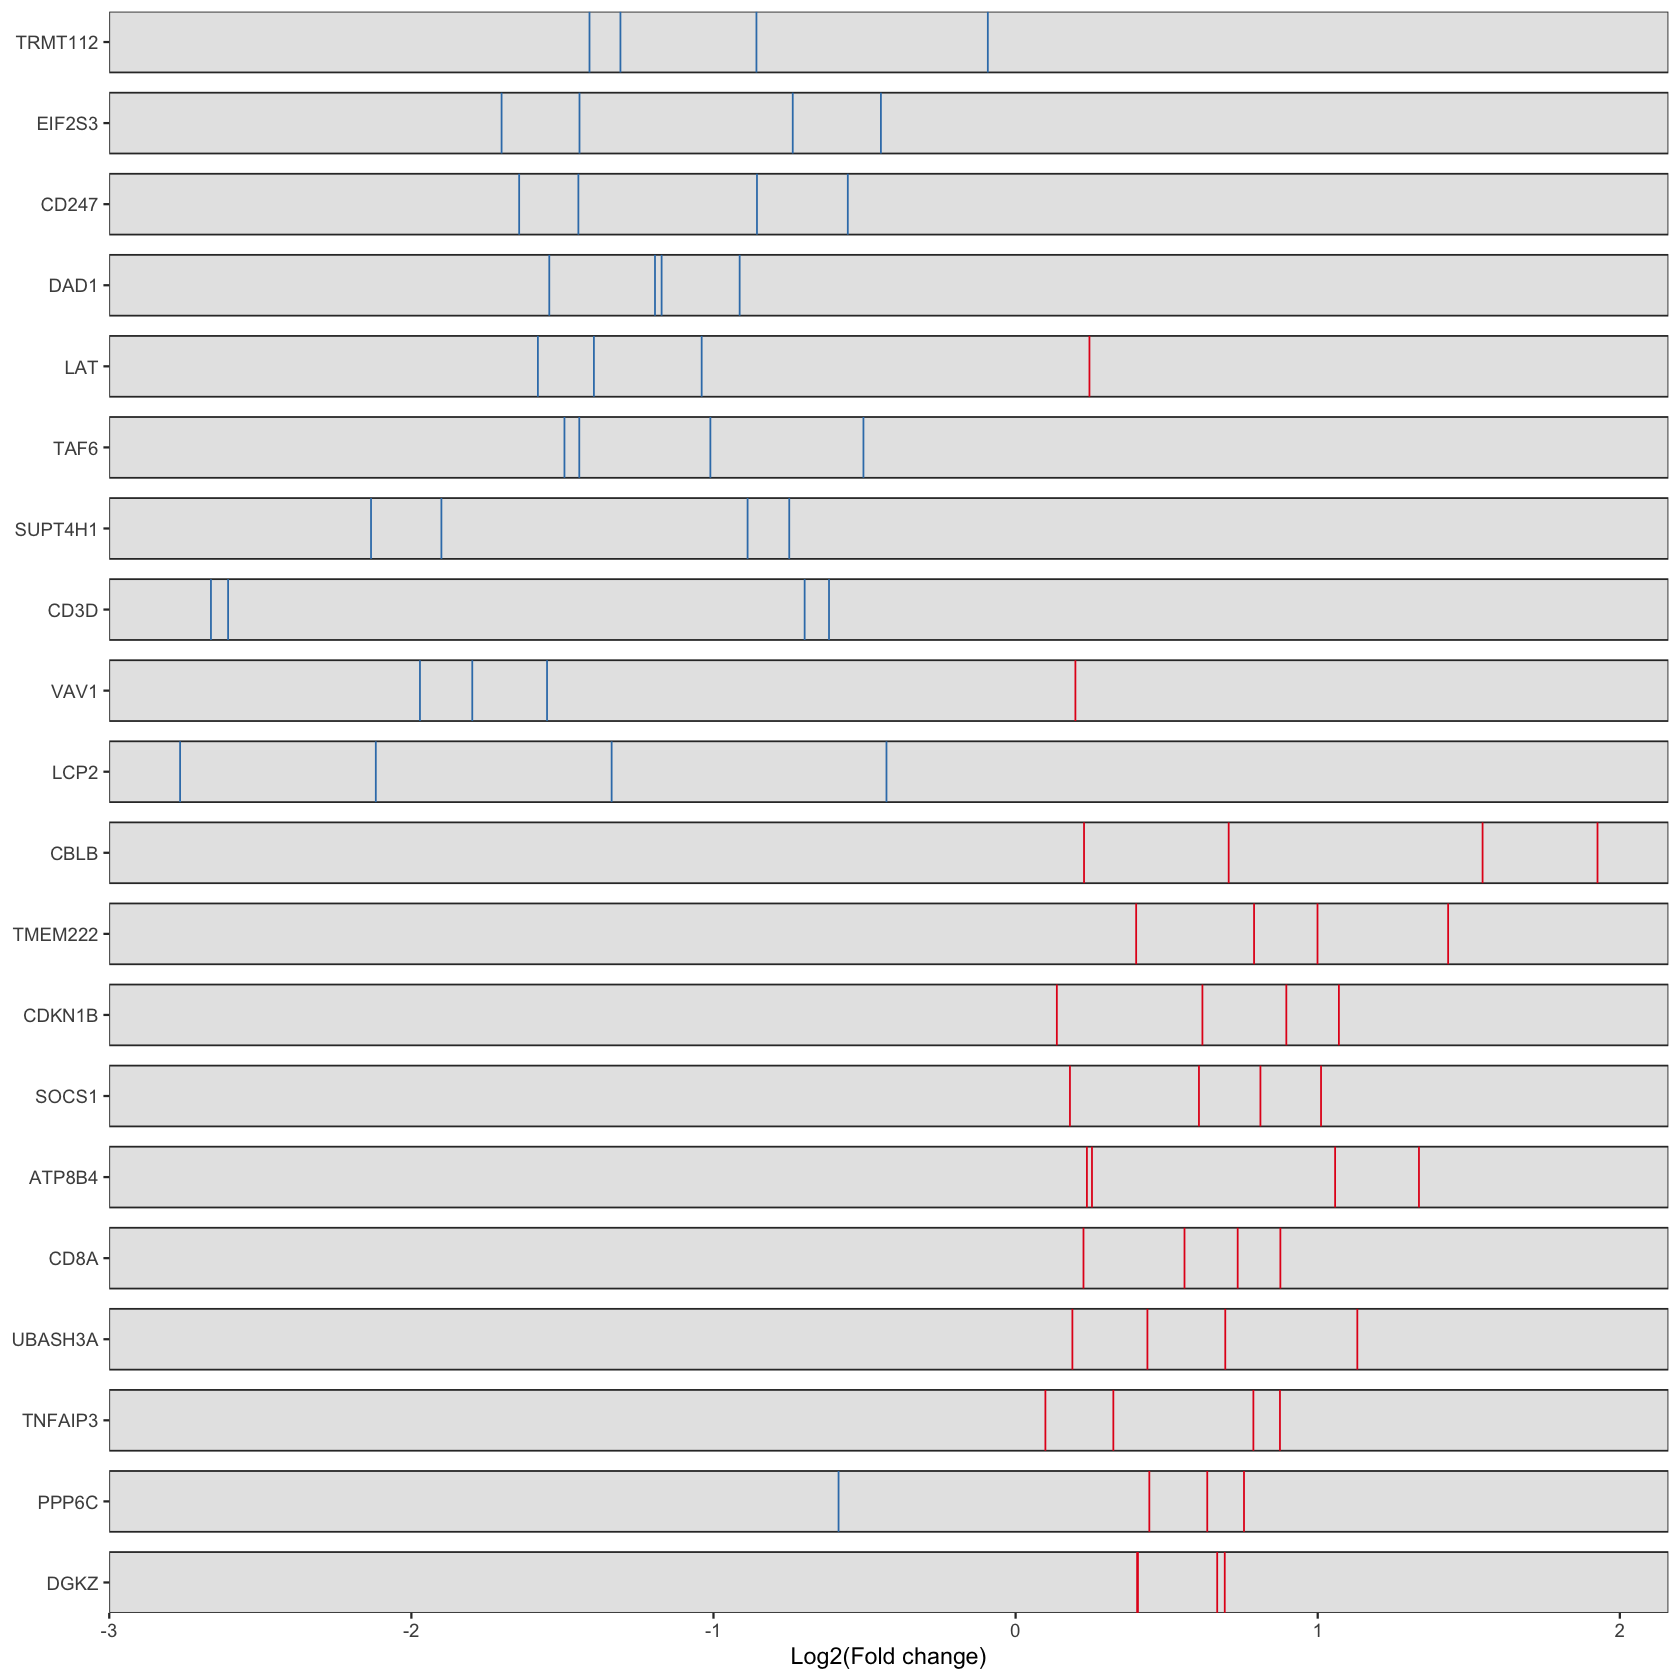

In [12]:
# visualize the rank of sgRNAs targeting top selected genes.
p2 <- sgRankView(sgrna_data, top = 10, bottom = 10)
print(p2)

## 3. Gene set enrichment analysis (GSEA)

Next, we'll perform a Gene Set Enrichment Analysis (GSEA) using the gene summary scores obtained from `mageck test` to identify any enriched KEGG pathways.

In [13]:
# create weighted gene list with scores
geneList <- gene_data$Score
names(geneList) <- gene_data$id
geneList

CBLB          TMEM222           CDKN1B            SOCS1 
      1.1255e+00       8.9430e-01       7.5724e-01       7.0862e-01 
          ATP8B4             CD8A          UBASH3A          TNFAIP3 
      6.5520e-01       6.4707e-01       5.6516e-01       5.5529e-01 
           PPP6C             DGKZ            RASA2             DGKA 
      5.3852e-01       5.3615e-01       5.2889e-01       5.1962e-01 
          RPRD1B              CD5             UBA6            BCAR1 
      5.0122e-01       4.9329e-01       4.6650e-01       4.6638e-01 
           TNIP1             FIBP            DUSP4            TCEB2 
      4.6445e-01       4.4065e-01       4.3388e-01       4.2891e-01 
         ZFP36L1           HSPA1A          IRF2BP2           ARID1A 
      4.2879e-01       4.2857e-01       4.2469e-01       4.2438e-01 
   NDUFC2-KCTD14             NMT1          PCDHGA7           NDUFA2 
      4.1825e-01       4.1640e-01       4.1577e-01       4.1093e-01 
            RNF7          C2orf68           MRPL35             CYC1 
      4.1089e-01       4.1062e-01       4.0408e-01       4.0320e-01 
         HMGCLL1             OPN3            PCBP2           LRRC26 
      3.9455e-01       3.8817e-01       3.8586e-01       3.8049e-01 
          REPIN1            INTS2           HOXA10          PIK3AP1 
      3.7901e-01       3.7738e-01       3.7653e-01       3.6533e-01 
           REG1A           UBE2E1             NMT2          NCKIPSD 
      3.6281e-01       3.6041e-01       3.5537e-01       3.5437e-01 
            USP4           TRIM39            MEF2D          ZDHHC23 
      3.4646e-01       3.4389e-01       3.4340e-01       3.3569e-01 
           MST1R            KHSRP           TRIM11     LOC100507462 
      3.3526e-01       3.3491e-01       3.3305e-01       3.3257e-01 
           TCFL5              CR2           SPTBN4         ADAMDEC1 
      3.3257e-01       3.3199e-01       3.3094e-01       3.3087e-01 
           PCF11             PI16          SMARCB1           BPIFB6 
      3.2721e-01       3.2645e-01       3.2643e-01       3.2610e-01 
           ISCA2            FUBP1     LOC100652758         CXorf49B 
      3.2511e-01       3.2187e-01       3.2155e-01       3.1909e-01 
           MOXD1          SLC6A14            RGS16           B3GNT2 
      3.1879e-01       3.1772e-01       3.1646e-01       3.1616e-01 
        C20orf96            IKZF3            PPTC7          MAGEA12 
      3.1553e-01       3.1535e-01       3.1524e-01       3.1401e-01 
         GPIHBP1          SLC25A1           CHMP2A            BIRC6 
      3.1289e-01       3.1285e-01       3.1185e-01       3.1107e-01 
            SOX4     LOC100129520           SCARF2           NKX2-1 
      3.1067e-01       3.1006e-01       3.0919e-01       3.0872e-01 
         PLEKHB1          NDUFB11            PICK1            CAPN5 
      3.0856e-01       3.0826e-01       3.0781e-01       3.0752e-01 
           CWC27          GAL3ST3            HSFY2           SLC9A3 
      3.0746e-01       3.0674e-01       3.0606e-01       3.0554e-01 
         SLC38A3            MYH11             STAR             TXN2 
      3.0541e-01       3.0540e-01       3.0446e-01       3.0310e-01 
           ESCO2          ATXN7L3            PATE4          PCDHB16 
      3.0278e-01       3.0143e-01       3.0013e-01       3.0007e-01 
           SMAD7            YARS2          B4GALT3          HLA-DRA 
      3.0002e-01       2.9943e-01       2.9740e-01       2.9739e-01 
            CBFB           MCOLN2             AGO1          MSANTD1 
      2.9728e-01       2.9591e-01       2.9590e-01       2.9570e-01 
          NIPAL3           DNAJC5           SEMA6B            FGF16 
      2.9529e-01       2.9400e-01       2.9399e-01       2.9386e-01 
           CDH10        SUPT20HL2            TOP2B           CTAG1B 
      2.9257e-01       2.9203e-01       2.9152e-01       2.9091e-01 
           CDK12             RBFA           GCSAML            KDM2B 
      2.9044e-01       2.8967e-01       2.8953e-01       2.8922e-01 
          

In [14]:
# GSEA using KEGG database; limiting to gene sets size 15-500
gseRes <- enrich.GSE(geneList, type = "KEGG", limit = c(15, 500), eps = 0)
gseRes@result

	7694 genes are mapped ...

preparing geneSet collections...

GSEA analysis...

Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (5.36% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”
leading edge analysis...

done...



ID           
KEGG_hsa05171 KEGG_hsa05171
KEGG_hsa03010 KEGG_hsa03010
KEGG_hsa03008 KEGG_hsa03008
KEGG_hsa03020 KEGG_hsa03020
KEGG_hsa03040 KEGG_hsa03040
KEGG_hsa05235 KEGG_hsa05235
KEGG_hsa04660 KEGG_hsa04660
KEGG_hsa00970 KEGG_hsa00970
KEGG_hsa04714 KEGG_hsa04714
KEGG_hsa03022 KEGG_hsa03022
KEGG_hsa03060 KEGG_hsa03060
KEGG_hsa04723 KEGG_hsa04723
KEGG_hsa04659 KEGG_hsa04659
KEGG_hsa04658 KEGG_hsa04658
KEGG_hsa04664 KEGG_hsa04664
KEGG_hsa04650 KEGG_hsa04650
KEGG_hsa03018 KEGG_hsa03018
KEGG_hsa00510 KEGG_hsa00510
KEGG_hsa04110 KEGG_hsa04110
KEGG_hsa00190 KEGG_hsa00190
KEGG_hsa04623 KEGG_hsa04623
KEGG_hsa00513 KEGG_hsa00513
KEGG_hsa05166 KEGG_hsa05166
KEGG_hsa03013 KEGG_hsa03013
KEGG_hsa05221 KEGG_hsa05221
KEGG_hsa05135 KEGG_hsa05135
KEGG_hsa04512 KEGG_hsa04512
KEGG_hsa04932 KEGG_hsa04932
KEGG_hsa05169 KEGG_hsa05169
KEGG_hsa04666 KEGG_hsa04666
⋮             ⋮            
KEGG_hsa04750 KEGG_hsa04750
KEGG_hsa01522 KEGG_hsa01522
KEGG_hsa04672 KEGG_hsa04672
KEGG_hsa05410 KEGG_hsa05410
KEGG_hsa04962 KEGG_hsa04962
KEGG_hsa05031 KEGG_hsa05031
KEGG_hsa00250 KEGG_hsa00250
KEGG_hsa00100 KEGG_hsa00100
KEGG_hsa04925 KEGG_hsa04925
KEGG_hsa00910 KEGG_hsa00910
KEGG_hsa04392 KEGG_hsa04392
KEGG_hsa04721 KEGG_hsa04721
KEGG_hsa00512 KEGG_hsa00512
KEGG_hsa00640 KEGG_hsa00640
KEGG_hsa04924 KEGG_hsa04924
KEGG_hsa04261 KEGG_hsa04261
KEGG_hsa04912 KEGG_hsa04912
KEGG_hsa04614 KEGG_hsa04614
KEGG_hsa00514 KEGG_hsa00514
KEGG_hsa05412 KEGG_hsa05412
KEGG_hsa04911 KEGG_hsa04911
KEGG_hsa04970 KEGG_hsa04970
KEGG_hsa00120 KEGG_hsa00120
KEGG_hsa04130 KEGG_hsa04130
KEGG_hsa00330 KEGG_hsa00330
KEGG_hsa05204 KEGG_hsa05204
KEGG_hsa04740 KEGG_hsa04740
KEGG_hsa04921 KEGG_hsa04921
KEGG_hsa00980 KEGG_hsa00980
KEGG_hsa00830 KEGG_hsa00830
              Description                                            NES       
KEGG_hsa05171 Coronavirus disease                                    -2.448230 
KEGG_hsa03010 Ribosome                                               -2.537622 
KEGG_hsa03008 Ribosome biogenesis in eukaryotes                      -2.664576 
KEGG_hsa03020 RNA polymerase                                         -2.528559 
KEGG_hsa03040 Spliceosome                                            -2.276245 
KEGG_hsa05235 PD-L1 expression and PD-1 checkpoint pathway in cancer -2.356879 
KEGG_hsa04660 T cell receptor signaling pathway                      -2.299869 
KEGG_hsa00970 Aminoacyl-tRNA biosynthesis                            -2.406123 
KEGG_hsa04714 Thermogenesis                                           1.911129 
KEGG_hsa03022 Basal transcription factors                            -2.353677 
KEGG_hsa03060 Protein export                                         -2.259024 
KEGG_hsa04723 Retrograde endocannabinoid signaling                    2.019913 
KEGG_hsa04659 Th17 cell differentiation                              -2.066221 
KEGG_hsa04658 Th1 and Th2 cell differentiation                       -2.127236 
KEGG_hsa04664 Fc epsilon RI signaling pathway                        -2.123281 
KEGG_hsa04650 Natural killer cell mediated cytotoxicity              -2.003033 
KEGG_hsa03018 RNA degradation                                        -2.052199 
KEGG_hsa00510 N-Glycan biosynthesis                                  -2.075324 
KEGG_hsa04110 Cell cycle                                             -1.875573 
KEGG_hsa00190 Oxidative phosphorylation                               1.793878 
KEGG_hsa04623 Cytosolic DNA-sensing pathway                          -2.060612 
KEGG_hsa00513 Various types of N-glycan biosynthesis                 -2.064043 
KEGG_hsa05166 Human T-cell leukemia virus 1 infection                -1.758145 
KEGG_hsa03013 Nucleocytoplasmic transport                            -1.877502 
KEGG_hsa05221 Acute myeloid leukemia                                 -1.901020 
KEGG_hsa05135 Yersinia infection                                     -1.780581 
KEGG_hsa04512 ECM-receptor interaction                                1.801928 
KEGG_hsa04932 Non-alcoholic fatty live

In [15]:
# look at top 25 KEGG hits
gseRes@result[1:25, c('Description', 'NES', 'p.adjust', 'Count')]

Description                                            NES      
KEGG_hsa05171 Coronavirus disease                                    -2.448230
KEGG_hsa03010 Ribosome                                               -2.537622
KEGG_hsa03008 Ribosome biogenesis in eukaryotes                      -2.664576
KEGG_hsa03020 RNA polymerase                                         -2.528559
KEGG_hsa03040 Spliceosome                                            -2.276245
KEGG_hsa05235 PD-L1 expression and PD-1 checkpoint pathway in cancer -2.356879
KEGG_hsa04660 T cell receptor signaling pathway                      -2.299869
KEGG_hsa00970 Aminoacyl-tRNA biosynthesis                            -2.406123
KEGG_hsa04714 Thermogenesis                                           1.911129
KEGG_hsa03022 Basal transcription factors                            -2.353677
KEGG_hsa03060 Protein export                                         -2.259024
KEGG_hsa04723 Retrograde endocannabinoid signaling                    2.019913
KEGG_hsa04659 Th17 cell differentiation                              -2.066221
KEGG_hsa04658 Th1 and Th2 cell differentiation                       -2.127236
KEGG_hsa04664 Fc epsilon RI signaling pathway                        -2.123281
KEGG_hsa04650 Natural killer cell mediated cytotoxicity              -2.003033
KEGG_hsa03018 RNA degradation                                        -2.052199
KEGG_hsa00510 N-Glycan biosynthesis                                  -2.075324
KEGG_hsa04110 Cell cycle                                             -1.875573
KEGG_hsa00190 Oxidative phosphorylation                               1.793878
KEGG_hsa04623 Cytosolic DNA-sensing pathway                          -2.060612
KEGG_hsa00513 Various types of N-glycan biosynthesis                 -2.064043
KEGG_hsa05166 Human T-cell leukemia virus 1 infection                -1.758145
KEGG_hsa03013 Nucleocytoplasmic transport                            -1.877502
KEGG_hsa05221 Acute myeloid leukemia                                 -1.901020
              p.adjust     Count
KEGG_hsa05171 3.330991e-13 62   
KEGG_hsa03010 1.089930e-12 52   
KEGG_hsa03008 7.630678e-12 42   
KEGG_hsa03020 3.234362e-09 20   
KEGG_hsa03040 1.645121e-07 52   
KEGG_hsa05235 1.645121e-07 27   
KEGG_hsa04660 1.661174e-07 24   
KEGG_hsa00970 1.131303e-06 16   
KEGG_hsa04714 2.354383e-06 72   
KEGG_hsa03022 2.545110e-06 19   
KEGG_hsa03060 1.032527e-05 12   
KEGG_hsa04723 1.286801e-05 66   
KEGG_hsa04659 3.911533e-05 27   
KEGG_hsa04658 3.911533e-05 24   
KEGG_hsa04664 4.979344e-05  9   
KEGG_hsa04650 7.217997e-05 21   
KEGG_hsa03018 1.565645e-04 26   
KEGG_hsa00510 2.555116e-04 16   
KEGG_hsa04110 6.199685e-04 39   
KEGG_hsa00190 7.471893e-04 41   
KEGG_hsa04623 7.471893e-04 17   
KEGG_hsa00513 8.693371e-04 14   
KEGG_hsa05166 9.069443e-04 52   
KEGG_hsa03013 1.119007e-03 45   
KEGG_hsa05221 1.485326e-03 25

### Visualize enrichment results

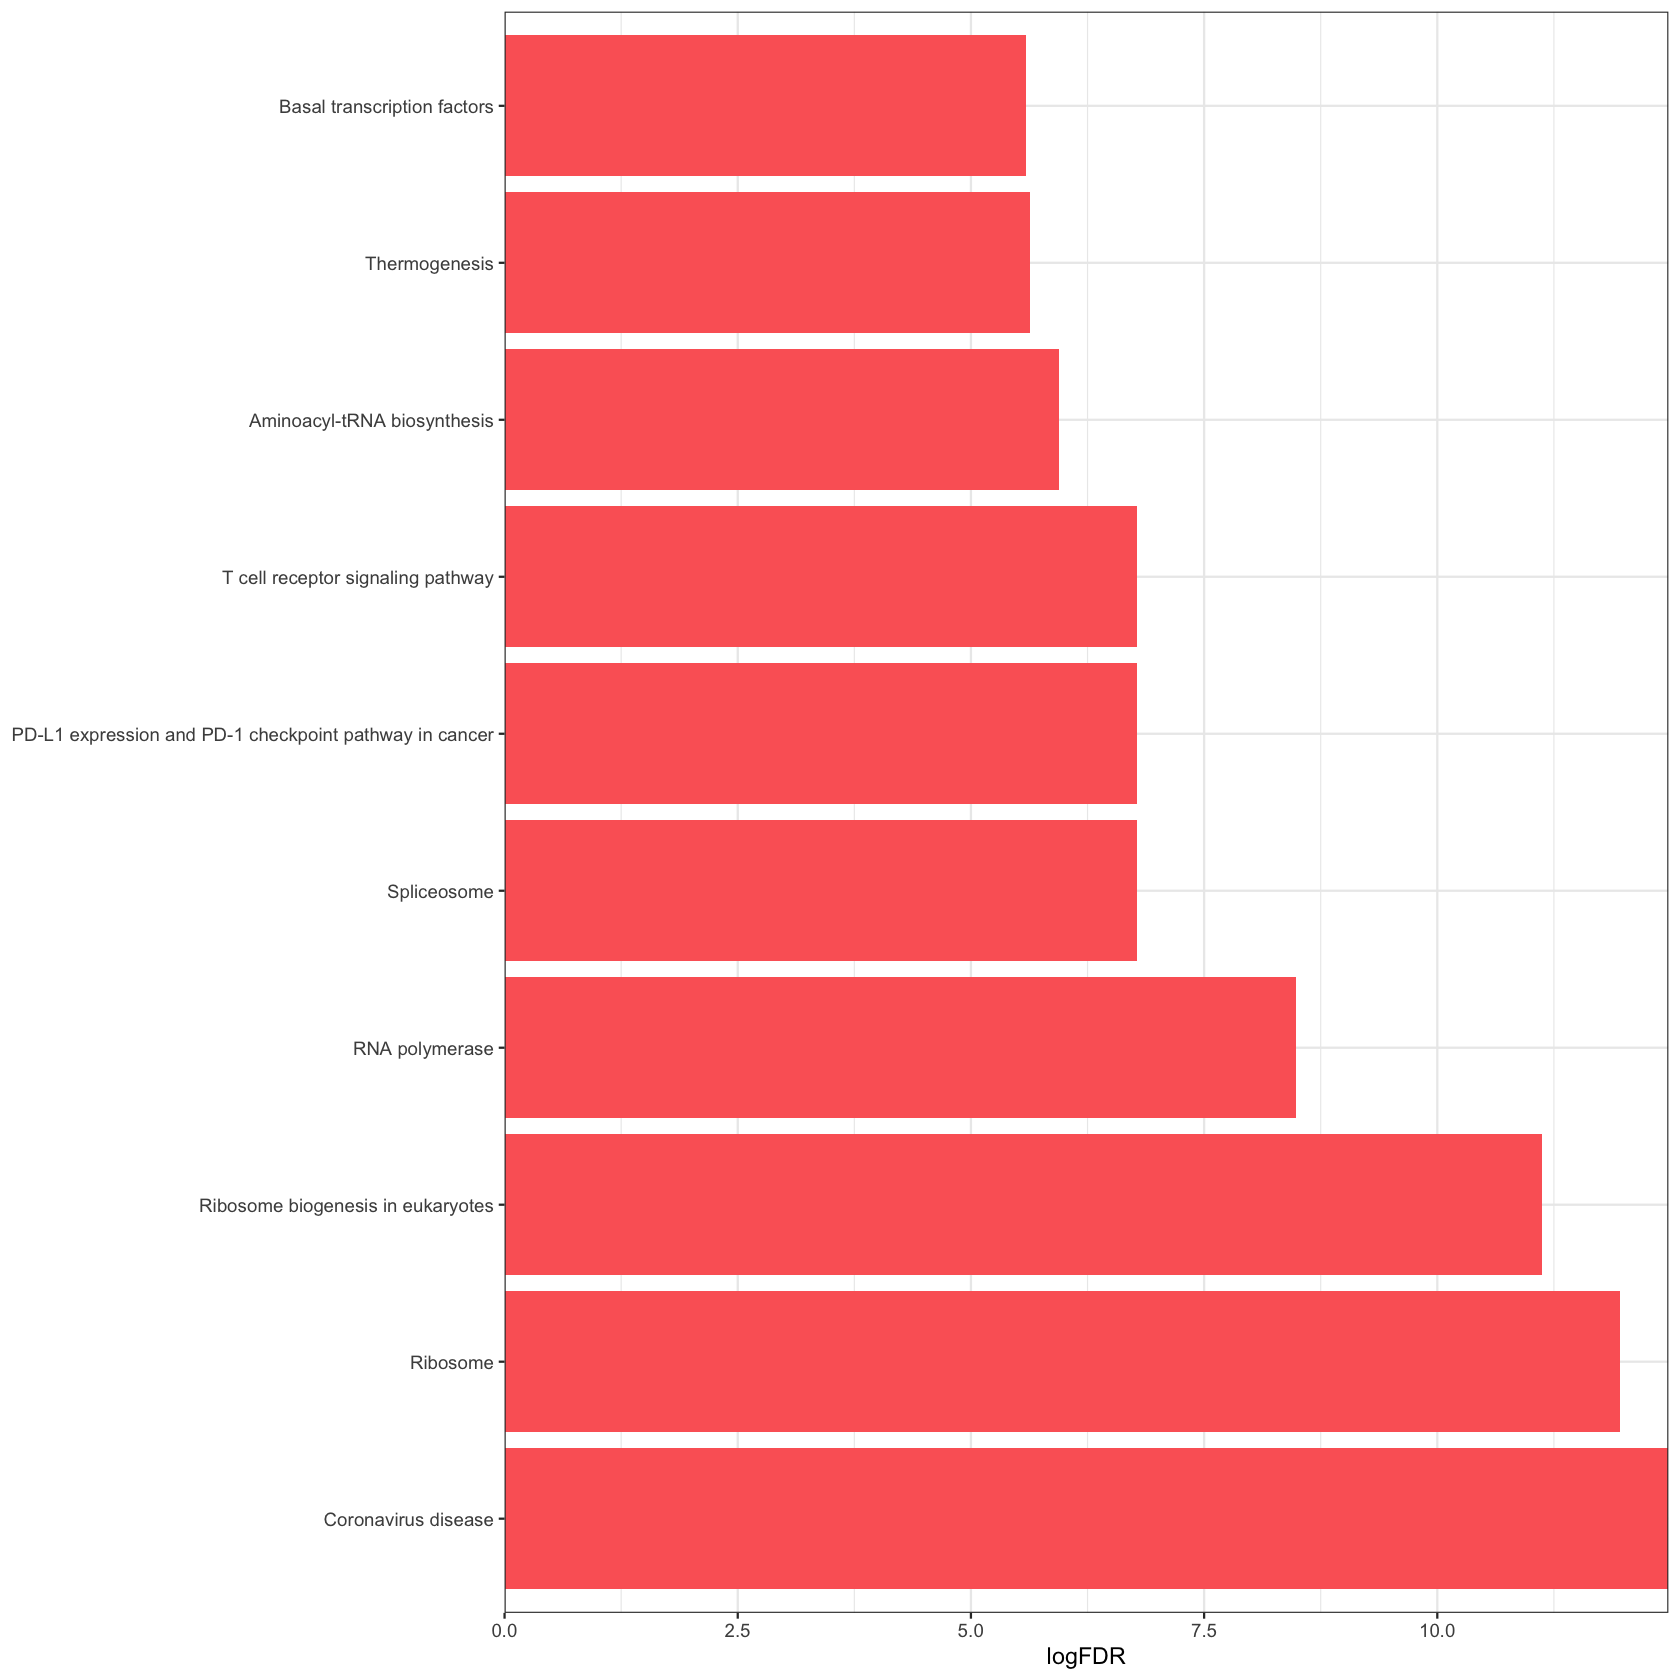

In [16]:
## visualize enrichment results
# barplot
df <- gseRes@result
df$logFDR <- -log10(df$p.adjust)
p <- BarView(df[1:10, ], "Description", 'logFDR')
p <- p + labs(x = NULL) + coord_flip()
p

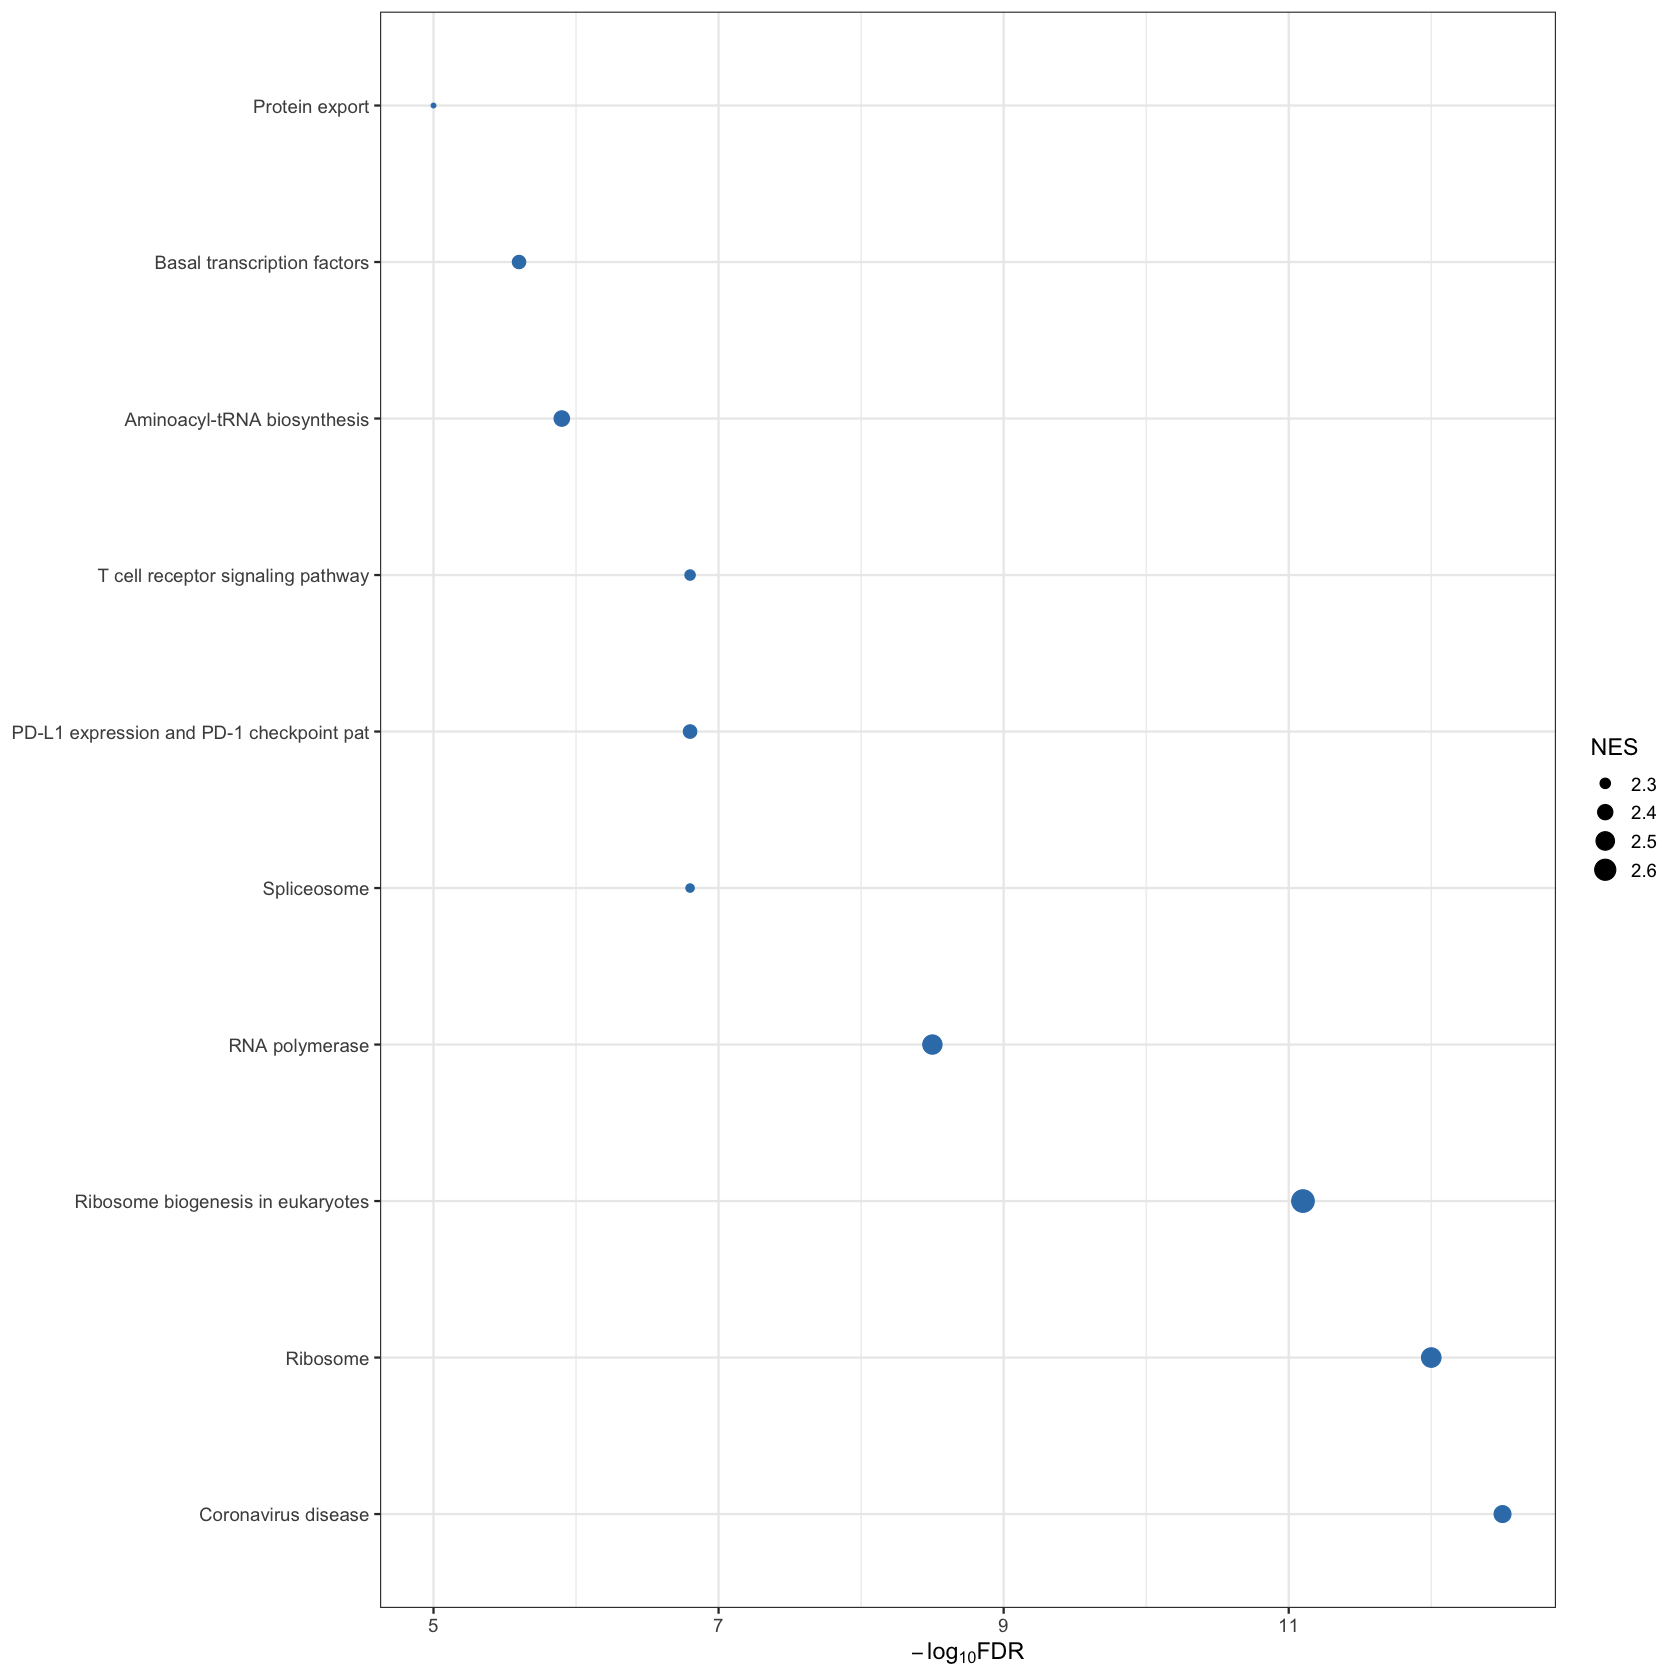

In [17]:
# dot plot
EnrichedView(gseRes, bottom = 10, mode = 1)

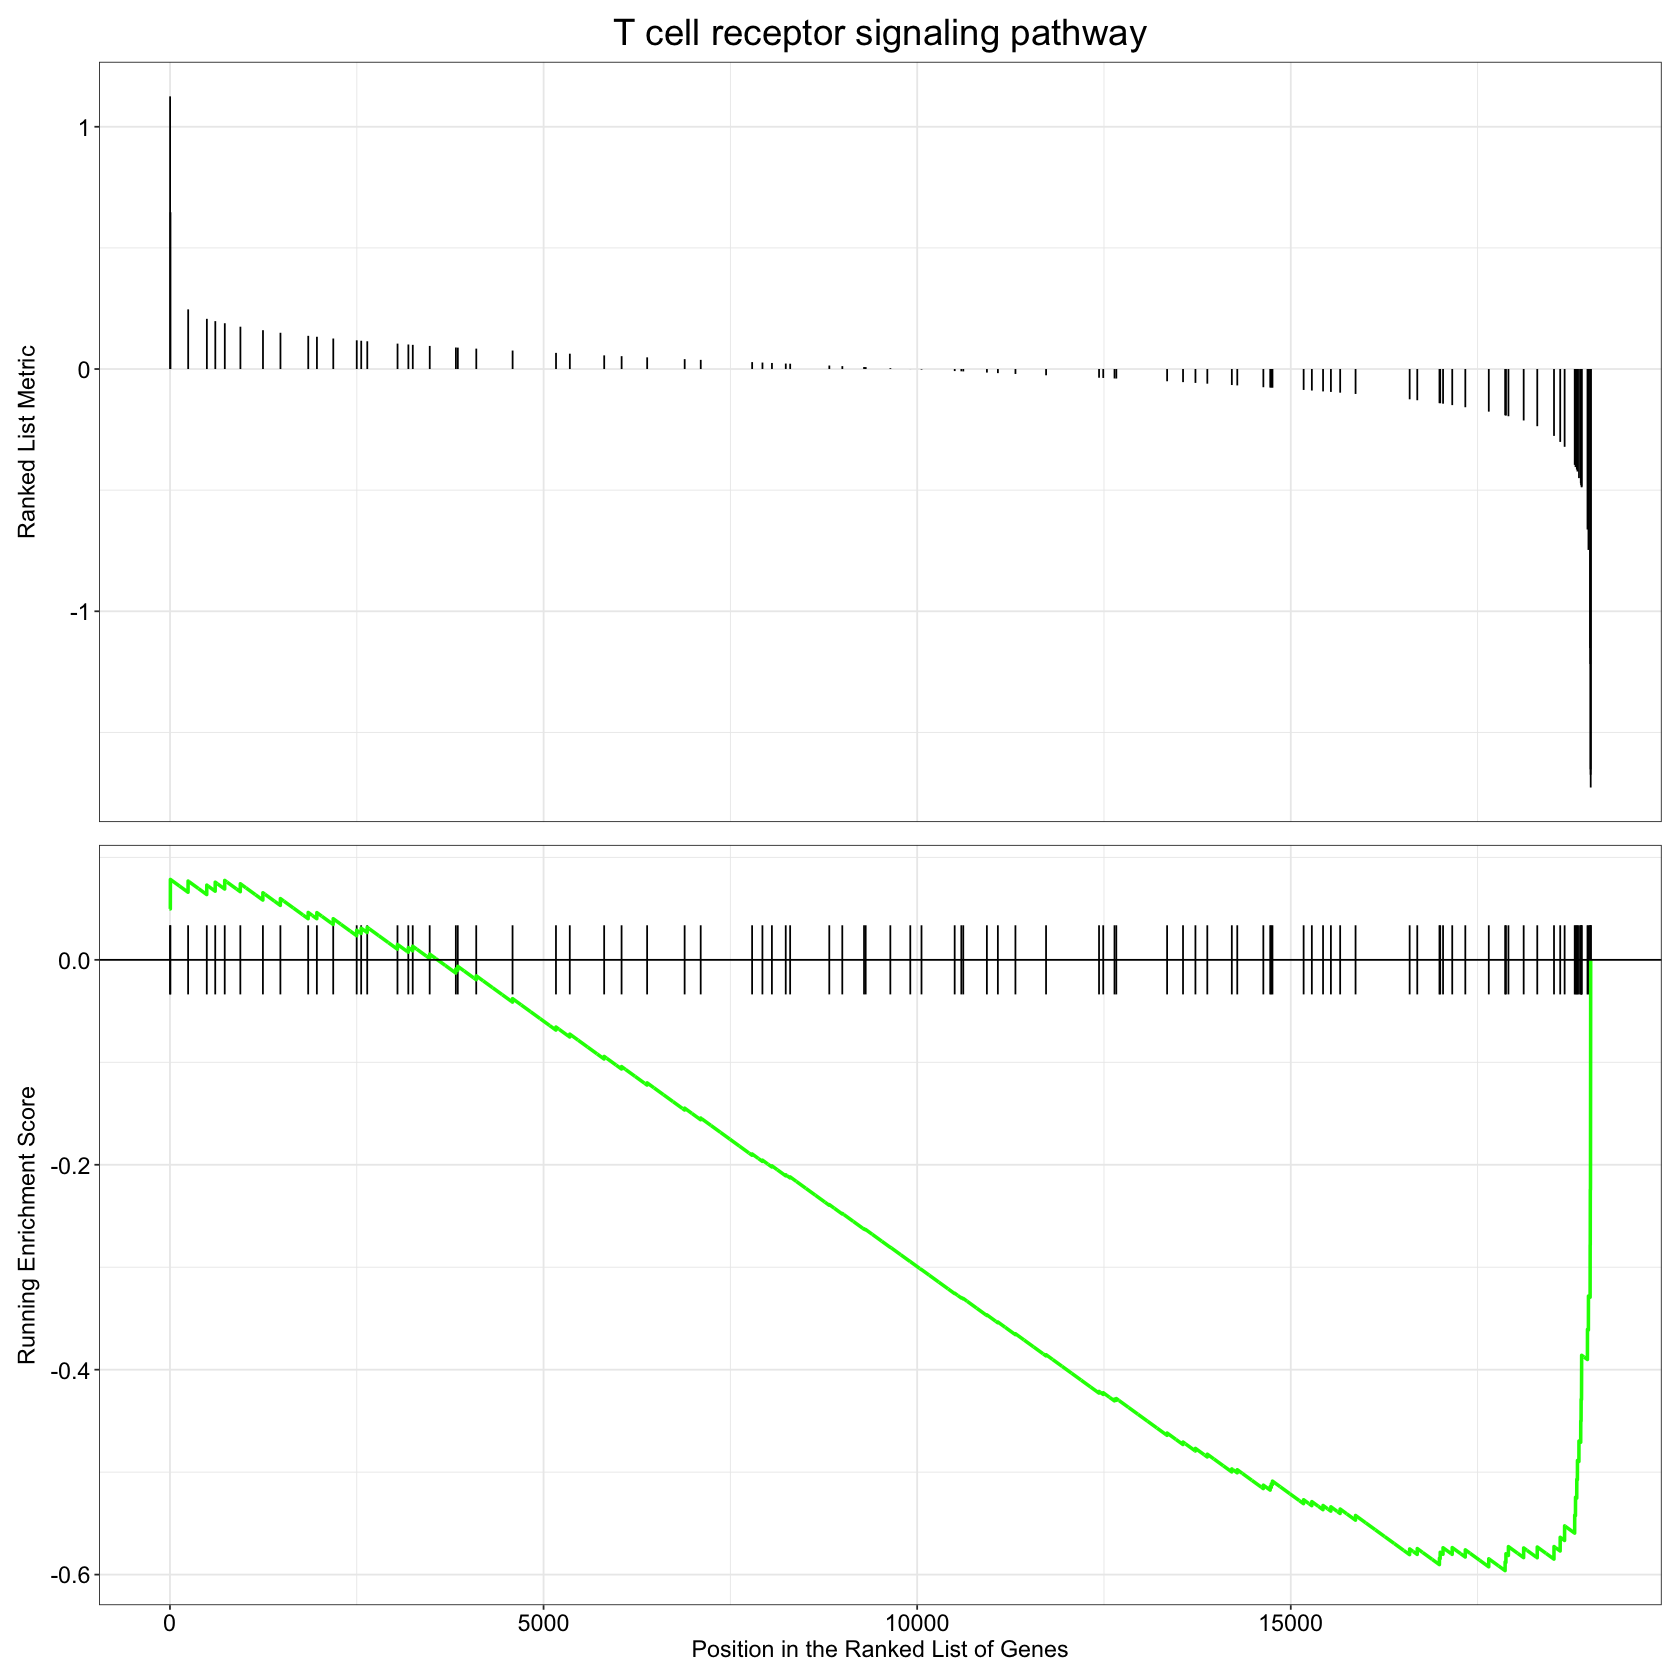

In [18]:
#gseaplot - T cell receptor signaling pathway
gseaplot(gseRes, geneSetID = 7, title = gseRes$Description[7])

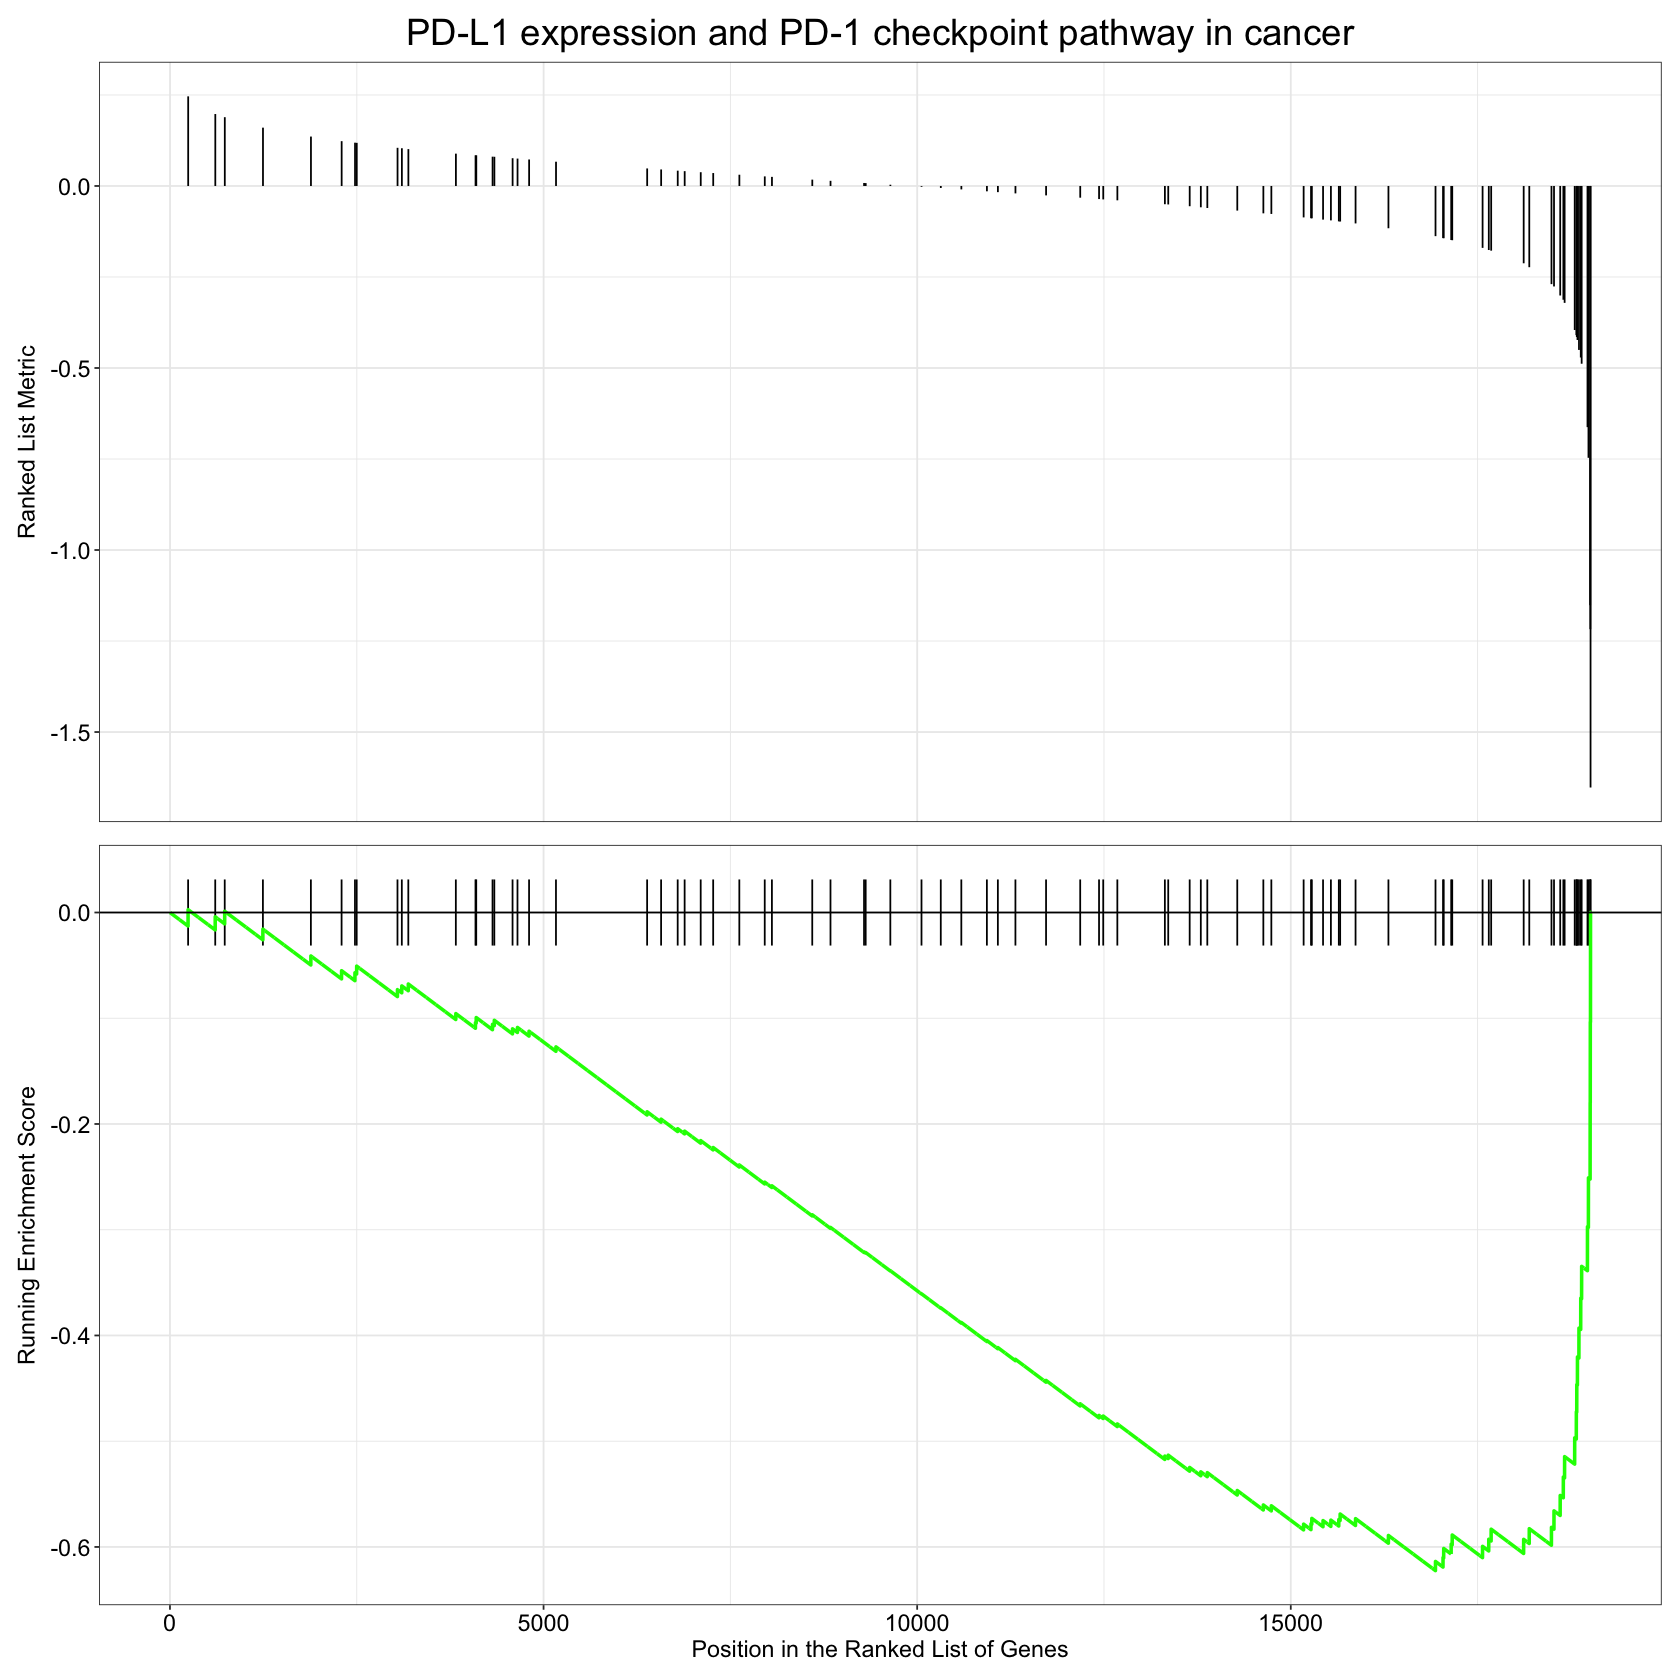

In [19]:
#gseaplot - PD-L1 expression and PD-1 checkpoint pathway in cancer
gseaplot(gseRes, geneSetID = 6, title = gseRes$Description[6])

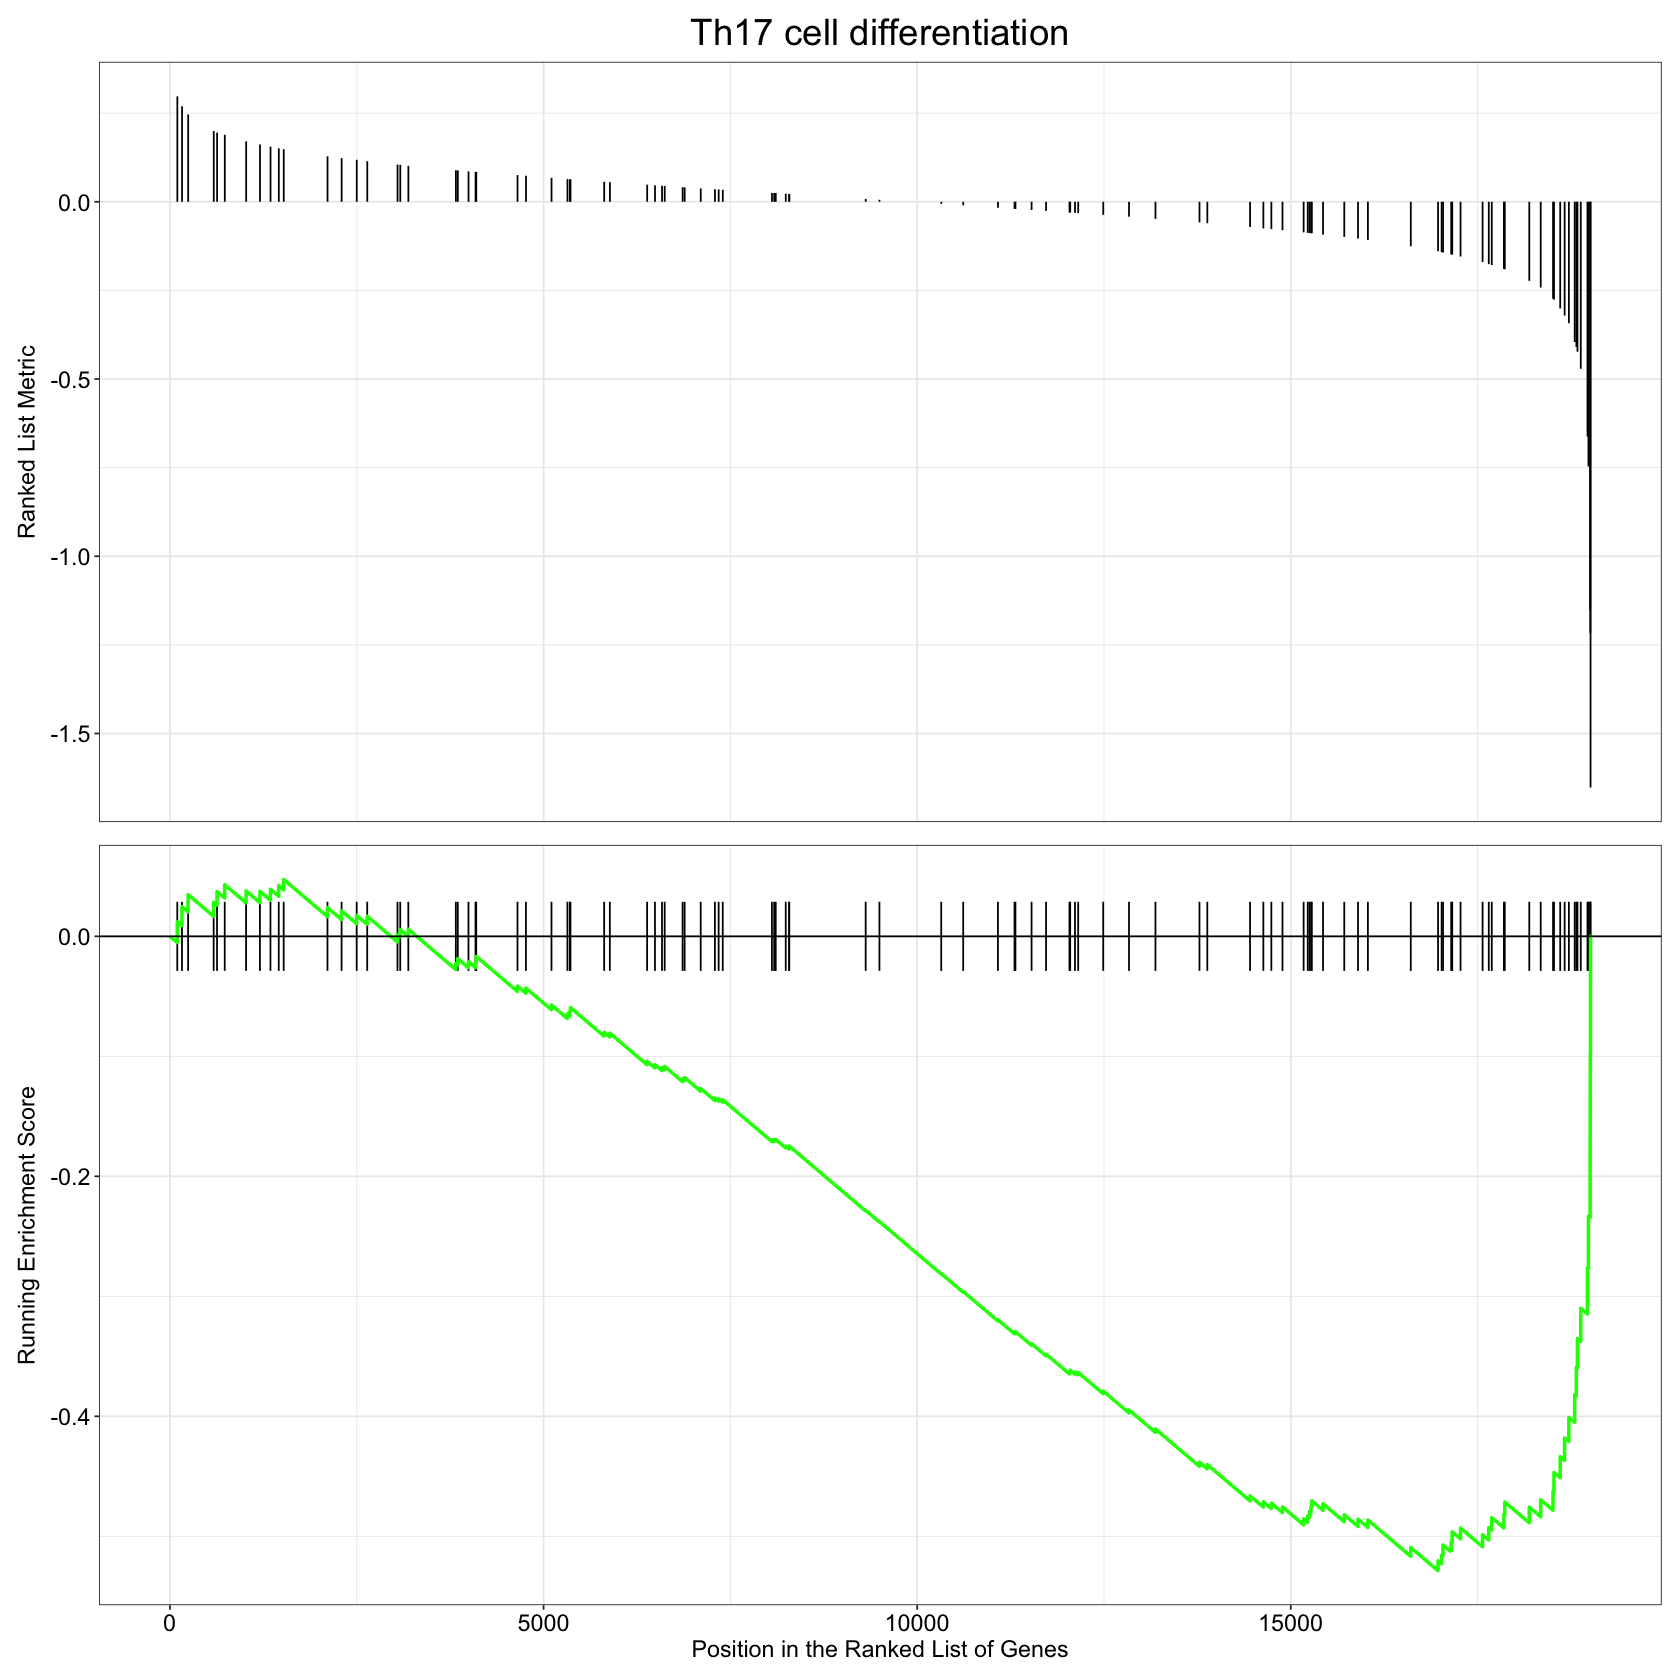

In [20]:
#gseaplot - Th17 cell differentiation
gseaplot(gseRes, geneSetID = 13, title = gseRes$Description[13])

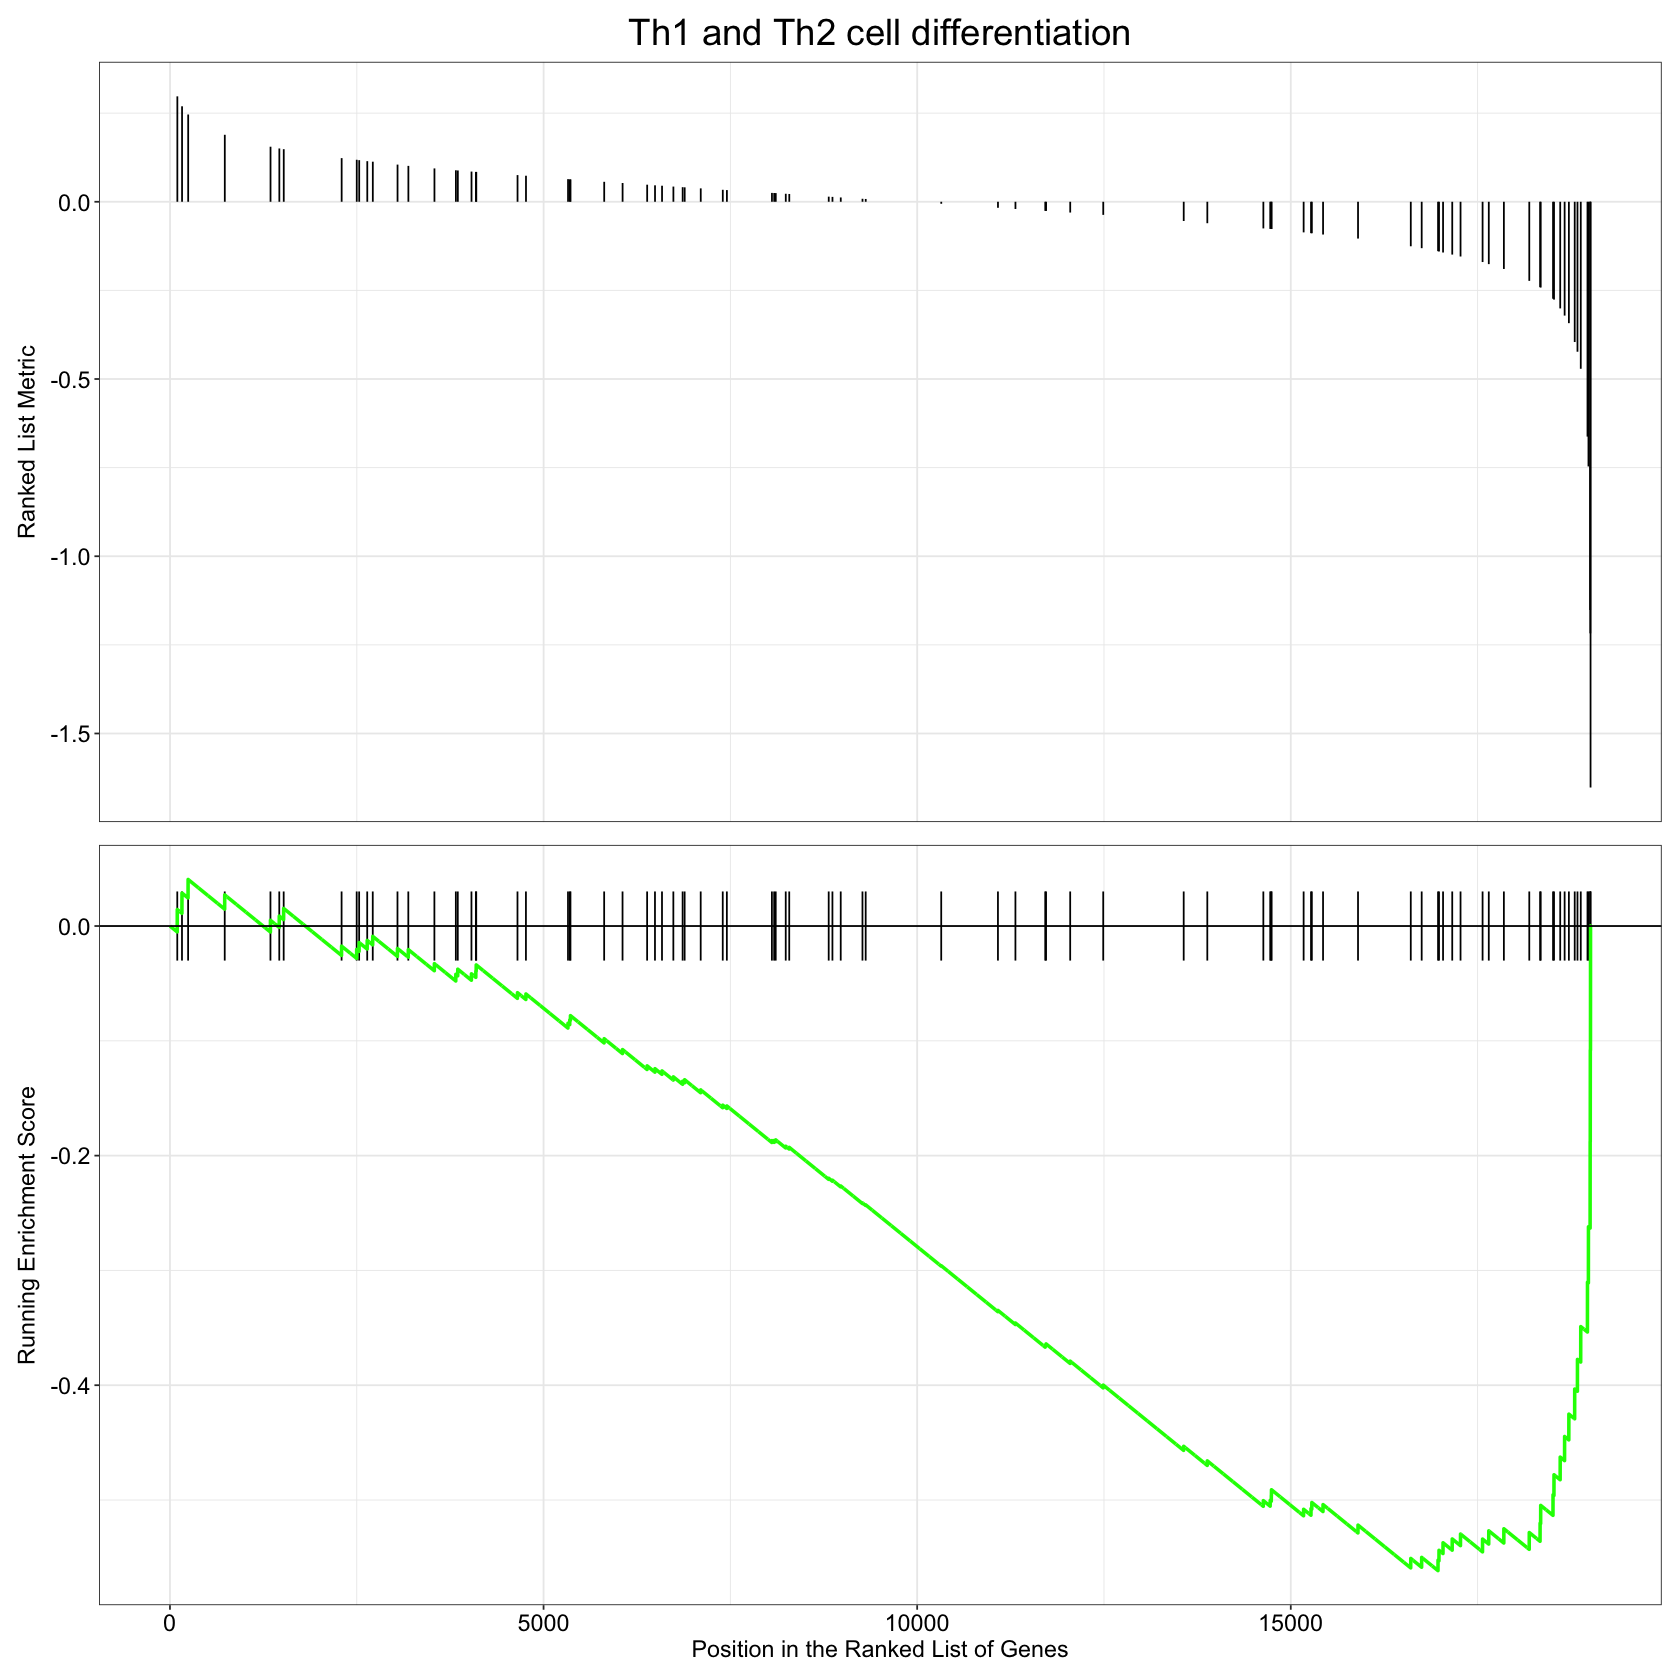

In [21]:
#gseaplot - Th1 and Th2 cell differentiation
gseaplot(gseRes, geneSetID = 14, title = gseRes$Description[14])

We see that the genes highlighted in this CRISPR screen analysis show enrichment in annotated pathways linked to T cell receptor signalling and T cell differentiation.

---

In [22]:
sessionInfo()

R version 4.3.2 (2023-10-31)
Platform: x86_64-apple-darwin13.4.0 (64-bit)
Running under: macOS Big Sur ... 10.16

Matrix products: default
BLAS/LAPACK: /Users/felixm/anaconda3/envs/mageck/lib/libopenblasp-r0.3.25.dylib;  LAPACK version 3.11.0

locale:
[1] en_US.UTF-8/en_US.UTF-8/en_US.UTF-8/C/en_US.UTF-8/en_US.UTF-8

time zone: America/Los_Angeles
tzcode source: system (macOS)

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
[1] ggrepel_0.9.4          ggplot2_3.4.4          clusterProfiler_4.10.0
[4] MAGeCKFlute_2.6.0     

loaded via a namespace (and not attached):
  [1] RColorBrewer_1.1-3            jsonlite_1.8.8               
  [3] magrittr_2.0.3                farver_2.1.1                 
  [5] fs_1.6.3                      zlibbioc_1.48.0              
  [7] vctrs_0.6.5                   memoise_2.0.1                
  [9] RCurl_1.98-1.13               ggtree_3.10.0                
 [11] base64enc_0.1-3